In [1]:
import os
import json
import glob
import copy
import copy
import itertools
import re
import pprint 
pp = pprint.PrettyPrinter(indent=4)

import numpy as np
import pylab as pl
import seaborn as sns
import pandas as pd
import statsmodels as sm
import cPickle as pkl

from scipy import stats as spstats

from pipeline.python.classifications import experiment_classes as util
from pipeline.python.classifications import aggregate_data_stats as aggr
from pipeline.python.classifications import rf_utils as rfutils
from pipeline.python import utils as putils
from pipeline.python.classifications import decode_utils as dec

from matplotlib.lines import Line2D
import matplotlib.patches as patches
from mpl_toolkits.axes_grid1 import make_axes_locatable


In [2]:
%matplotlib notebook

In [3]:
# Set colors
visual_area, area_colors = putils.set_threecolor_palette()
dpi = putils.set_plot_params()


In [4]:
pl.rcParams['axes.labelsize']

16.0

# Dataset info

In [5]:
#### Set trace ID and FOV/state type
traceid = 'traces001'
fov_type = 'zoom2p0x'
state = 'awake'
aggregate_dir = '/n/coxfs01/julianarhee/aggregate-visual-areas'

#### Responsive params
responsive_test = 'nstds' # 'nstds' #'ROC' #None
nstd_thr=10
responsive_thr = nstd_thr if responsive_test=='nstds' else 0.05 #0.05 #None
n_stds = None if responsive_test=='ROC' else 2.5 #None

response_type = 'dff'

response_str = '%s_%s-thr-%.2f' % (response_type, responsive_test, responsive_thr) 
print(response_str)

dff_nstds-thr-10.00


# Output dir

In [6]:
pupildir = os.path.join(aggregate_dir, 'behavior-state', 'pupil')
print(pupildir)

if not os.path.exists(pupildir):
    os.makedirs(pupildir)

/n/coxfs01/julianarhee/aggregate-visual-areas/behavior-state/pupil


#### Get metadata for stimulus

In [7]:
experiment = 'blobs'

In [8]:
# Get all data sets
sdata = aggr.get_aggregate_info(traceid=traceid, fov_type=fov_type, state=state)
sdata['datakey'] = ['%s_%s_fov%i' % (session, animalid, fovnum) \
                        for session, animalid, fovnum in sdata[['session', 'animalid', 'fovnum']].values]

sdata[['visual_area', 'animalid', 'session', 'fov']].drop_duplicates().groupby(['visual_area']).count()

,animalid,session,fov
visual_area,,,
Li,26,26,26
Lm,22,22,22
V1,18,18,18


In [9]:
# Get blob metadata only - and only if have RFs
sdata_exp = pd.concat([g for k, g in sdata.groupby(['animalid', 'session', 'fov']) if 
                        (experiment in g['experiment'].values 
                         and ('rfs' in g['experiment'].values or 'rfs10' in g['experiment'].values)) ])

sdata_exp[['visual_area', 'animalid', 'session', 'fov']].drop_duplicates().groupby(['visual_area']).count()

,animalid,session,fov
visual_area,,,
Li,13,13,13
Lm,12,12,12
V1,11,11,11


#### Drop duplicates and whatnot fovs

In [10]:
stim_filterby = None #'first'

if experiment=='blobs':
    has_gratings=False
    g_str = 'hasgratings' if has_gratings else 'blobsonly'
else:
    g_str = 'gratingsonly'
resp_filter_str = 'stim-filter-%s_%s_%s' % (stim_filterby, g_str, response_str)

In [11]:
# Drop duplicates and whatnot fovs
if experiment=='blobs':
    exp_dkeys = aggr.get_blob_datasets(filter_by=stim_filterby, has_gratings=has_gratings, as_dict=True)
elif experiment == 'gratings':
    exp_dkeys = aggr.get_gratings_datasets(filter_by=stim_filterby, as_dict=True)

dictkeys = [d for d in list(itertools.chain(*exp_dkeys.values()))]
stim_datakeys = ['%s_%s_fov%i' % (s.split('_')[0], s.split('_')[1], 
                   sdata[(sdata['animalid']==s.split('_')[1]) 
                         & (sdata['session']==s.split('_')[0])]['fovnum'].unique()[0]) for s in dictkeys]
expmeta = dict((k, [dv for dv in stim_datakeys for vv in v if vv in dv]) for k, v in exp_dkeys.items())

curr_sdata = sdata_exp[sdata_exp['datakey'].isin(stim_datakeys)].copy().reset_index(drop=True)
print('[%s] %i unique datakeys' % (experiment, len(stim_datakeys)))
curr_sdata[['visual_area', 'animalid', 'session', 'fov']].drop_duplicates().groupby(['visual_area']).count()

[blobs] 37 unique datakeys


,animalid,session,fov
visual_area,,,
Li,13,13,13
Lm,12,12,12
V1,11,11,11


In [12]:
#### Create data ID for labeling figures with data-types
data_id = '|'.join([traceid, resp_filter_str])
print(data_id)


traces001|stim-filter-None_blobsonly_dff_nstds-thr-10.00


In [13]:
curr_sdata.shape, sdata_exp.shape, len(stim_datakeys)

((141, 7), (141, 7), 37)

# Load gratings or blobs

In [14]:
trial_epoch = 'stimulus'
MEANS = aggr.load_aggregate_data(experiment, responsive_test=responsive_test, responsive_thr=responsive_thr, 
               response_type=response_type, epoch=trial_epoch)


...loading: /n/coxfs01/julianarhee/aggregate-visual-areas/data-stats/aggr_blobs_trialmeans_traces001_nstds-thr-10.00_dff_stimulus.pkl


In [15]:
# glob.glob(os.path.join(stats_dir, 'aggr_%s_trialmeans_*%s*_%s_baseline.pkl' 
#                                                % (experiment, responsive_test, response_type)))

In [16]:
# aggr_baselines_dfile = glob.glob(os.path.join(stats_dir, 
#                                 'aggr_%s_trialmeans_*%s*_%s_baseline.pkl'
#                                               % (experiment, responsive_test, response_type)))[0]

# print(aggr_baselines_dfile)
# with open(aggr_baselines_dfile, 'rb') as f:
#     BAS = pkl.load(f)

# Face tracker data

#### Check which datakeys are missing DLC -- ALL data

In [17]:
from pipeline.python.eyetracker import dlc_utils as dlcutils

In [18]:
dlc_dsets = dlcutils.get_datasets_with_dlc(sdata)
dlc_datakeys = dlc_dsets['datakey'].unique()
sdata_datakeys = sdata['datakey'].unique()
print("%i of %i datasets with DLC." % (len(dlc_datakeys),len(sdata_datakeys)))


Extracting results from scorer: DLC_resnet50_facetrackingJan25shuffle1_391800
Checking for existing results: /n/coxfs01/julianarhee/face-tracking/facetracking-jyr-2020-01-25/pose-analysis
35 of 66 datasets with DLC.


#### Only include dsets with face-tracking

In [19]:
dsets = dlcutils.get_datasets_with_dlc(curr_sdata)

dlc_datakeys = dsets['datakey'].unique()
exp_datakeys = curr_sdata['datakey'].unique()
print("%i of %i datasets with DLC." % (len(dlc_datakeys),len(exp_datakeys)))
missing_dlc = [i for i in exp_datakeys if i not in dlc_datakeys]
print("Need %i datasets analyzed:" % len(missing_dlc), missing_dlc)

Extracting results from scorer: DLC_resnet50_facetrackingJan25shuffle1_391800
Checking for existing results: /n/coxfs01/julianarhee/face-tracking/facetracking-jyr-2020-01-25/pose-analysis
35 of 36 datasets with DLC.
('Need 1 datasets analyzed:', ['20191008_JC091_fov1'])


In [359]:

import shutil
os.rmdir(glob.glob(os.path.join(rootdir, animalid, session, fov, 'combined_blobs_*'))[0])

OSError: [Errno 2] No such file or directory: '/n/coxfs01/2p-data/JC091/20190614/FOV1_zoom2p0x/combined_blobs_*'

#### Loading existing extracted pupil data

In [58]:
face_feature = 'pupil_area'
snapshot = 391800


if face_feature == 'pupil_area':
    pupil_fpath = os.path.join(aggregate_dir, 'behavior-state', 
                               '%s_pupil_area_traces_snapshot-%i.pkl' % (experiment, snapshot))
else:
    pupil_fpath = glob.glob(os.path.join(aggregate_dir, 'behavior-state', 
                                         '%s_pupil-traces_snapshot-%i.pkl' % (experiment, snapshot)))[0]
print(pupil_fpath)

# This is a dict, keys are datakeys
with open(pupil_fpath, 'rb') as f:
    PUPIL = pkl.load(f)

/n/coxfs01/julianarhee/aggregate-visual-areas/behavior-state/blobs_pupil_area_traces_snapshot-391800.pkl


In [21]:
missing_dlc = [i for i in exp_datakeys if '%s_%s' % (i, experiment) not in PUPIL.keys()]
print("Missing %i datasets for DCL extraction:" % len(missing_dlc))
for i in missing_dlc: print('... %s' % i);

Missing 1 datasets for DCL extraction:
... 20191008_JC091_fov1


In [60]:
PUPIL[PUPIL.keys()[0]]

for k, v in PUPIL.items():
    p_max = v['pupil_area'].max()
    v['pupil_fraction'] = v['pupil_area']/p_max
    PUPIL[k] = v

In [22]:
# Get trial alignment info
rootdir = '/n/coxfs01/2p-data'
animalid = 'JC097'
session = '20190616'
fovnum = 1
alignment_info = aggr.get_trial_alignment(animalid, session, fovnum, experiment, traceid=traceid)
# alignment_info
iti_pre_ms = float(alignment_info['iti_pre'])*1000
iti_post_ms = float(alignment_info['iti_post'])*1000
print("ITI pre/post: %.1f ms, %.1f ms" % (iti_pre_ms, iti_post_ms))

ITI pre/post: 1000.0 ms, 1000.0 ms


In [28]:
if len(missing_dlc) > 0:
    for dkey in missing_dlc:
        print("[%s] getting extracted feature: %s" % (dkey, face_feature))
        session, animalid, fov = dkey.split('_')
        fovnum = int(fov[3:])
        fov = 'FOV%i_zoom2p0x' % fovnum

        #### Get labels
        labels_dfile = glob.glob(os.path.join(rootdir, animalid, session, fov, 'combined_*%s*' % experiment, 'traces',
                              '%s*' % traceid, 'data_arrays', 'labels.npz'))[0]
        l = np.load(labels_dfile)
        labels = pd.DataFrame(data=l['labels_data'], columns=l['labels_columns'])

        #### Load pupil data
        facemeta, pupildata = dlcutils.load_pose_data(animalid, session, fovnum, experiment, dlc_results_dir, 
                                                      feature_list=[face_feature], epoch='trial_alignment', 
                                                      pre_ITI_ms=iti_pre_ms, post_ITI_ms=iti_post_ms)

        #### Parse pupil data into traces
        pupiltraces = dlcutils.get_pose_traces(facemeta, pupildata, labels, feature='pupil_area')

        #### Add to dict
        datakey ='%s_%s_fov%i_%s' % (session, animalid, fovnum, experiment)  
        PUPIL[datakey] = pupiltraces


    # This is a dict, keys are datakeys
    with open(pupil_fpath, 'wb') as f:
        pkl.dump(PUPIL, f, protocol=pkl.HIGHEST_PROTOCOL)


In [106]:
dlc_project_dir = '/n/coxfs01/julianarhee/face-tracking/facetracking-jyr-2020-01-25'

dlc_results_dir = os.path.join(dlc_project_dir, 'pose-analysis')
analysis_dir = dlc_results_dir

In [375]:
datakey = '20191018_JC113_fov1'
dlc_outfiles = sorted(glob.glob(os.path.join(analysis_dir, '%s*.h5' % datakey)), key=putils.natural_keys)
dlc_outfiles

['/n/coxfs01/julianarhee/face-tracking/facetracking-jyr-2020-01-25/pose-analysis/20191018_JC113_fov1_blobs_f1DLC_resnet50_facetrackingJan25shuffle1_391800.h5',
 '/n/coxfs01/julianarhee/face-tracking/facetracking-jyr-2020-01-25/pose-analysis/20191018_JC113_fov1_blobs_f2DLC_resnet50_facetrackingJan25shuffle1_391800.h5',
 '/n/coxfs01/julianarhee/face-tracking/facetracking-jyr-2020-01-25/pose-analysis/20191018_JC113_fov1_blobs_f3DLC_resnet50_facetrackingJan25shuffle1_391800.h5',
 '/n/coxfs01/julianarhee/face-tracking/facetracking-jyr-2020-01-25/pose-analysis/20191018_JC113_fov1_blobs_f4DLC_resnet50_facetrackingJan25shuffle1_391800.h5',
 '/n/coxfs01/julianarhee/face-tracking/facetracking-jyr-2020-01-25/pose-analysis/20191018_JC113_fov1_blobs_f5DLC_resnet50_facetrackingJan25shuffle1_391800.h5',
 '/n/coxfs01/julianarhee/face-tracking/facetracking-jyr-2020-01-25/pose-analysis/20191018_JC113_fov1_blobs_f6DLC_resnet50_facetrackingJan25shuffle1_391800.h5',
 '/n/coxfs01/julianarhee/face-tracking/f

In [361]:
datakey

'20190602_JC091_fov1'

In [363]:
animalid = 'JC091'
session = '20190602'
fov='FOV1_zoom2p0x'
pre_ITI_ms=1000
post_ITI_ms=1000

#### Get labels
labels_dfile = glob.glob(os.path.join(rootdir, animalid, session, fov, 'combined_*%s*' % experiment, 'traces',
                      '%s*' % traceid, 'data_arrays', 'labels.npz'))[0]
l = np.load(labels_dfile)
labels = pd.DataFrame(data=l['labels_data'], columns=l['labels_columns'])

#### Load pupil data
facemeta, pupildata = dlcutils.load_pose_data(animalid, session, fovnum, experiment, dlc_results_dir, 
                                              feature_list=[face_feature], epoch='trial_alignment', 
                                              pre_ITI_ms=iti_pre_ms, post_ITI_ms=iti_post_ms)

Loading pose data (dlc)
('[blobs] Found runs:', ['1', '2', '3', '4', '5', '6'])
... finding movies for dset: 20190602_JC091_fov1_blobs
(0, '/n/coxfs01/2p-data/eyetracker_tmp/20190602_JC091_fov1_blobs_f1_20190602151722650866')
(1, '/n/coxfs01/2p-data/eyetracker_tmp/20190602_JC091_fov1_blobs_f2_20190602161127488646')
(2, '/n/coxfs01/2p-data/eyetracker_tmp/20190602_JC091_fov1_blobs_f3_20190602171902936040')
(3, '/n/coxfs01/2p-data/eyetracker_tmp/20190602_JC091_fov1_blobs_f4_20190602185634063844')
(4, '/n/coxfs01/2p-data/eyetracker_tmp/20190602_JC091_fov1_blobs_f5_20190602195543014871')
(5, '/n/coxfs01/2p-data/eyetracker_tmp/20190602_JC091_fov1_blobs_f6_20190602203012939604')
----- File 1.-----
... Eyetracker dir: 20190602_JC091_fov1_blobs_f1_20190602151722650866
... Full run duration: 16.90 min
----- File 2.-----
... Eyetracker dir: 20190602_JC091_fov1_blobs_f2_20190602161127488646
... Full run duration: 14.59 min
----- File 3.-----
... Eyetracker dir: 20190602_JC091_fov1_blobs_f3_2019060

In [366]:
from pipeline.python.eyetracker import dlc_utils as dlcutils

In [367]:
pupiltraces = dlcutils.get_pose_traces(facemeta, pupildata, labels, feature='pupil_area')

Parsing pose data with MW
('Missing 737 trials total', [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 183, 184, 185, 186, 187, 188, 189, 190, 191, 192, 193, 194, 195, 196, 197, 198, 199, 200, 201, 202, 203, 204, 205, 206, 207, 208, 209, 210, 211, 212, 213, 214, 

<IPython.core.display.Javascript object>


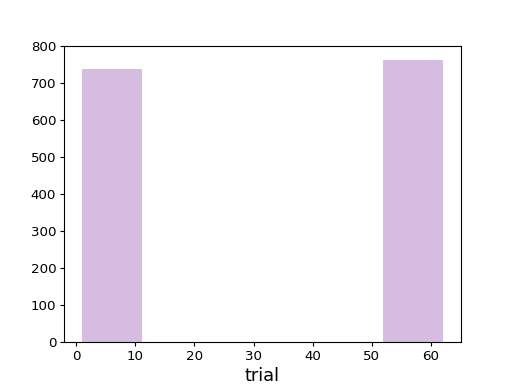

In [369]:
pl.figure()
sns.distplot(pupiltraces['trial'].value_counts(), kde=False)

In [324]:
pupiltraces.shape

(90859, 3)

In [373]:
pupiltraces['trial'].value_counts()<50

1471    False
1364    False
565     False
629     False
917     False
981     False
1077    False
1109    False
1301    False
1365    False
1461    False
566     False
918     False
982     False
1078    False
1110    False
1302    False
1366    False
1462    False
567     False
631     False
1460    False
1300    False
1079    False
1108    False
561     False
1105    False
1457    False
562     False
914     False
        ...  
239      True
271      True
303      True
335      True
240      True
208      True
176      True
144      True
112      True
80       True
48       True
16       True
94       True
1167     True
126      True
975      True
911      True
847      True
815      True
751      True
687      True
655      True
623      True
591      True
158      True
495      True
463      True
399      True
367      True
32       True
Name: trial, Length: 1499, dtype: bool

In [371]:
datakey

'20190602_JC091_fov1'

In [374]:
min_nframes = 50
#tcounts = pd.DataFrame((pdf['trial'].value_counts()<min_nframes))
tcounts = pd.DataFrame(pupiltraces['trial'].value_counts()<min_nframes)

funky_trials = tcounts.index[tcounts['trial']]
pdf[pdf['trial'].isin(funky_trials)]['trial'].value_counts()
len(funky_trials)

737

In [183]:
for tix, (trial, g) in enumerate(fmeta.groupby(['trial'])):
    g

In [339]:
currtrial = 1198 #106 # 109
g = fmeta[fmeta['trial']==currtrial]
g

,end_ix,movie,run_label,run_num,start_ix,trial_in_run,config,trial
1197,13811,20190614_JC091_fov1_blobs_f5,5,5,13744,198,config025,1198


In [345]:
(eye_start, eye_end), = g[['start_ix', 'end_ix']].values
run_label = str(int(g['run_label'].values[0]))
print(run_label, eye_start, eye_end)
print(eye_end-eye_start+1)

('5', 13744, 13811)
68


In [341]:
pupil_dists =  pupildata[pupildata['run_label']==run_label]['pupil_area']
eye_values = pupil_dists[eye_start:eye_end]
all(np.isnan(eye_values))

False

In [342]:
last_ix = pupil_dists.index[-1]
print(last_ix)
eye_end>last_ix
# 485.993599

17400


False

In [343]:
pupildata[pupildata['run_label']==run_label][eye_start:eye_end]

,index,pupil_area,pupil_maj,pupil_min,run_label,run_num
13744,13744,358.749506,11.539622,9.895776,5,5
13745,13745,358.410601,11.532637,9.892415,5,5
13746,13746,360.162467,11.575916,9.903602,5,5
13747,13747,358.018744,11.548885,9.867698,5,5
13748,13748,358.110945,11.556334,9.863877,5,5
13749,13749,356.827298,11.532729,9.848636,5,5
13750,13750,358.152409,11.557437,9.864077,5,5
13751,13751,355.122646,11.496461,9.832509,5,5
13752,13752,354.123673,11.486402,9.813435,5,5
13753,13753,354.410131,11.482853,9.824409,5,5


In [344]:
pupiltraces[pupiltraces['trial']==currtrial]

,config,pupil_area,trial
0,config025,358.749506,1198
1,config025,358.410601,1198
2,config025,360.162467,1198
3,config025,358.018744,1198
4,config025,358.110945,1198
5,config025,356.827298,1198
6,config025,358.152409,1198
7,config025,355.122646,1198
8,config025,354.123673,1198
9,config025,354.410131,1198


In [337]:
pdf = PUPIL['%s_blobs' % datakey].copy()
pdf[pdf['trial']==currtrial]

,config,pupil_area,trial,pupil_fraction
0,config024,564.903237,106,0.152315
1,config024,565.835116,106,0.152566
2,config024,560.132019,106,0.151029
3,config024,558.691295,106,0.150640
4,config024,545.261655,106,0.147019
5,config024,545.600022,106,0.147110
6,config024,546.509631,106,0.147356
7,config024,552.974506,106,0.149099
8,config024,551.250557,106,0.148634
9,config024,553.401378,106,0.149214


In [338]:
pdf['trial'].value_counts()

1198    68
457     67
114     67
110     67
1173    67
234     67
184     67
779     62
305     62
36      62
177     62
497     62
715     62
971     62
651     62
1456    62
277     62
341     62
1443    62
331     62
1428    62
1379    62
1187    62
1123    62
1393    62
1457    62
533     62
178     62
1290    62
306     62
        ..
361     61
489     61
616     61
249     60
1174    56
1199    56
185     55
116     55
458     55
113     55
235     55
109     51
1250    38
125      1
151      1
238      1
20       1
123      1
398      1
108      1
241      1
124      1
107      1
240      1
69       1
250      1
239      1
218      1
203      1
202      1
Name: trial, Length: 1500, dtype: int64

In [103]:
dlc_results_dir

'/n/coxfs01/julianarhee/face-tracking/facetracking-jyr-2020-01-25'

In [31]:
for dkey in sdata_exp[sdata_exp['visual_area']=='V1']['datakey'].unique():
    if '%s_%s' % (dkey, experiment) not in PUPIL.keys():
        print("missing: %s" % dkey)
        continue
    print(dkey, PUPIL['%s_%s' % (dkey, experiment)]['pupil_area'].min(), PUPIL['%s_%s' % (dkey, experiment)]['pupil_area'].max())
    


('20190420_JC076_fov1', 29.7542528541342, 2698.850284804228)
('20190501_JC076_fov1', 43.8027635196512, 1512.6268916174708)
('20190507_JC083_fov1', 60.29653277898383, 1684.0583695540736)
('20190510_JC083_fov1', 41.70270904006818, 805.3732843941274)
('20190511_JC083_fov1', 64.23984863648069, 1310.2595483268522)
('20190522_JC084_fov1', 55.073919034780424, 1512.6217072997263)
('20190622_JC085_fov1', 243.54176262181758, 5292.631114096762)
('20190613_JC097_fov1', 59.92635926653636, 3151.942550565534)
('20190616_JC097_fov1', 91.6205755177363, 4433.129025638984)
('20190617_JC097_fov1', 79.52719392465777, 4994.465941495201)
('20191006_JC110_fov1', 56.27964447770161, 3600.41671559622)


In [53]:
for dkey in sdata_exp[sdata_exp['visual_area']=='Li']['datakey'].unique():
    if '%s_%s' % (dkey, experiment) not in PUPIL.keys():
        print("missing: %s" % dkey)
        continue
    print(dkey, PUPIL['%s_%s' % (dkey, experiment)]['pupil_area'].min(), PUPIL['%s_%s' % (dkey, experiment)]['pupil_area'].max())
    

('20190502_JC076_fov1', 55.23043533477066, 2637.349764343908)
('20190605_JC090_fov1', 58.63091710875337, 2086.491195141086)
('20190602_JC091_fov1', 159.5377794616639, 1871.1595789472303)
('20190606_JC091_fov1', 100.98744026722346, 1878.3210035296406)
('20190607_JC091_fov1', 62.627762024621106, 2021.6855883098526)
('20190614_JC091_fov1', 127.08591608199461, 3708.7772958144105)
missing: 20191008_JC091_fov1
('20190609_JC099_fov1', 146.1181111311171, 2136.766734499528)
('20190612_JC099_fov1', 137.4254936825414, 2556.558360428254)
('20190617_JC099_fov1', 298.1609874468438, 5869.282171231653)
('20191018_JC113_fov1', 98.05980171749512, 7029.695551542352)
('20191105_JC117_fov1', 127.72859824773455, 4569.386909818708)
('20191111_JC120_fov1', 169.94531884926445, 7883.813718301389)


# ROI assignments

In [23]:
from pipeline.python.retinotopy import segment_retinotopy as seg

In [24]:
rois = seg.get_cells_by_area(sdata_exp)
cells = aggr.get_active_cells_in_current_datasets(rois, MEANS)


20190502_JC076_fov1
20191008_JC091_fov1


# Load traces

In [25]:
from scipy import interpolate
def resample_traces(samples, in_rate=44.65, out_rate=20.0):

    n_in_samples= len(samples)
    in_samples = samples.copy() #[rid, :] #np.array(tracef['File%03d' % curr_file][trace_type][:])
    in_tpoints = np.arange(0, n_in_samples) #len(in_samples))

    n_out_samples = round(n_in_samples * out_rate/in_rate)
    #print("N out samples: %i" % n_out_samples)

    flinear = interpolate.interp1d(in_tpoints, in_samples, axis=0)

    out_tpoints = np.linspace(in_tpoints[0], in_tpoints[-1], n_out_samples)
    out_samples = flinear(out_tpoints)
    #print("Out samples:", out_samples.shape)
    
    return out_tpoints, out_samples

def bin_pupil_traces(pupiltraces, feature_name='pupil',in_rate=20.0, out_rate=22.325, 
                          min_nframes=None, iti_pre_ms=1000):
    pupildfs = []
    if min_nframes is None:
        min_nframes = int(round(np.mean([len(g) for p, g in pupiltraces.groupby(['trial'])])))
    #print(min_nframes)
    for trial, g in pupiltraces.groupby(['trial']):
        if len(g[feature_name]) < min_nframes:
            npad = min_nframes - len(g[feature_name])
            vals = np.pad(g[feature_name].values, pad_width=((0, npad)), mode='edge')
        else:
            vals = g[feature_name].values[0:min_nframes]
        #print(len(vals))
        out_ixs, out_s = resample_traces(vals, in_rate=in_rate, out_rate=out_rate)
        currconfig = g['config'].unique()[0]
        new_stim_on = (iti_pre_ms/1E3)*out_rate #int(np.where(abs(out_ixs-stim_on) == min(abs(out_ixs-stim_on)))[0])
        pupildfs.append(pd.DataFrame({feature_name: out_s, 
                                       'stim_on': [new_stim_on for _ in np.arange(0, len(out_s))],
                                       'config': [currconfig for _ in np.arange(0, len(out_s))],
                                       'trial': [trial for _ in np.arange(0, len(out_s))]} ))
    pupildfs = pd.concat(pupildfs, axis=0).reset_index(drop=True)
    return pupildfs


def zscore_array(v):
    return (v-v.mean())/v.std()

In [73]:
pupiltraces['trial'].value_counts().unique()

array([62, 61,  1])

In [77]:
datakey

'20190602_JC091_fov1'

In [81]:
PUPIL['%s_blobs' % datakey].dropna()['trial'].value_counts()

1471    62
1305    62
298     62
921     62
1321    62
1049    62
1081    62
1113    62
1177    62
1401    62
714     62
1097    62
1465    62
585     62
553     62
1416    62
1320    62
602     62
554     62
601     62
1093    62
555     62
920     62
1099    62
1048    62
1080    62
1112    62
1176    62
715     62
1304    62
        ..
907      1
875      1
843      1
779      1
747      1
140      1
172      1
204      1
652      1
940      1
908      1
876      1
844      1
312      1
780      1
748      1
344      1
684      1
620      1
236      1
588      1
376      1
492      1
460      1
396      1
364      1
332      1
300      1
268      1
32       1
Name: trial, Length: 1472, dtype: int64

In [83]:
pdf = PUPIL['%s_blobs' % datakey]
pdf[pdf['trial']==300]

,config,pupil_area,trial,pupil_fraction
0,config019,905.928984,300,0.484154


In [85]:
datakey='20190522_JC084_fov1'
PUPIL['%s_blobs' % datakey].dropna()['trial'].value_counts().dropna()

749     62
1392    62
368     62
432     62
292     62
228     62
460     62
164     62
149     62
140     62
1379    62
1315    62
1483    62
1419    62
1355    62
1227    62
293     62
1163    62
277     62
241     62
369     62
405     62
469     62
779     62
533     62
739     62
459     62
789     62
1201    62
139     62
        ..
1192    61
936     61
552     61
1255    61
1447    61
40      61
104     61
296     61
360     61
488     61
64      61
616     61
872     61
808     61
1036     1
741      1
1070     1
1058     1
1155     1
1030     1
986      1
1031     1
681      1
1035     1
601      1
870      1
1059     1
1029     1
680      1
1034     1
Name: trial, Length: 1500, dtype: int64

In [26]:
def get_pupil_df(pupil_r, trial_epoch='pre', new_stim_on=20., nframes_on=20.):
    '''
    Turn resampled pupil traces into reponse vectors
    
    trial_epoch : (str)
        'pre': Use PRE-stimulus period for response metric.
        'stim': Use stimulus period
        'all': Use full trial period
    
    new_stim_on: (int)
        Frame index for stimulus start (only needed if trial_epoch is 'pre' or 'stim')
        
    pupil_r : resampled pupil traces (columns are trial, frame, pupil_area, frame_int, frame_ix)
    '''
    if trial_epoch=='pre':
        pupildf = pd.concat([g[g['frame_ix'].isin(np.arange(0, new_stim_on))].mean(axis=0) \
                            for t, g in pupil_r.groupby(['trial'])], axis=1).T
    elif trial_epoch=='stim':
        pupildf = pd.concat([g[g['frame_ix'].isin(np.arange(new_stim_on, new_stim_on+nframes_on))].mean(axis=0) \
                            for t, g in pupil_r.groupby(['trial'])], axis=1).T
    else:
        pupildf = pd.concat([g.mean(axis=0) for t, g in pupil_r.groupby(['trial'])], axis=1).T
    #print(pupildf.shape)

    return pupildf

def resample_pupil_traces(pupiltraces, in_rate=20., out_rate=20., iti_pre_ms=1000, desired_nframes=60, 
                         feature_name='pupil_area'):
    '''
    resample pupil traces to make sure we have exactly the right # of frames to match neural data
    '''
    binned_pupil = bin_pupil_traces(pupiltraces, feature_name=face_feature,
                                         in_rate=in_rate, out_rate=out_rate, 
                                         min_nframes=desired_nframes, iti_pre_ms=iti_pre_ms)
    trials_ = sorted(pupiltraces['trial'].unique())
    frames_ = np.arange(0, desired_nframes)
    pupil_trialmat = pd.DataFrame(np.vstack([p[feature_name].values for trial, p in binned_pupil.groupby(['trial'])]),
                                  index=trials_, columns=frames_)
    pupil_r = pupil_trialmat.T.unstack().reset_index().rename(columns={'level_0': 'trial', 
                                                                       'level_1': 'frame',
                                                                       0: feature_name})
    pupil_r['frame_int'] = [int(round(f)) for f in pupil_r['frame']]
    interp_frame_ixs = list(sorted(pupil_r['frame'].unique()))
    pupil_r['frame_ix'] = [interp_frame_ixs.index(f) for f in pupil_r['frame']]

    return pupil_r
    
# def match_trials(neuraldf, pupiltraces, labels_all):
#     '''
#     make sure neural data trials = pupil data trials
#     '''
#     trials_with_pupil = list(pupiltraces['trial'].unique())
#     trials_with_neural = list(labels_all['trial_num'].unique())
#     n_pupil_trials = len(trials_with_pupil)
#     n_neural_trials = len(trials_with_neural)

#     labels = labels_all[labels_all['trial_num'].isin(trials_with_pupil)].copy()
#     if n_pupil_trials > n_neural_trials:
#         pupiltraces = pupiltraces[pupiltraces['trial'].isin(trials_with_neural)]
#     elif n_pupil_trials < n_neural_trials:    
#         print(labels.shape, labels_all.shape)
#         neuraldf = neuraldf.loc[trials_with_pupil]
    
#     return neuraldf, pupiltraces

def match_trials(neuraldf, pupiltraces):
    '''
    make sure neural data trials = pupil data trials
    '''
    trials_with_pupil = list(pupiltraces['trial'].unique())
    trials_with_neural = list(labels_all['trial_num'].unique())
    n_pupil_trials = len(trials_with_pupil)
    n_neural_trials = len(trials_with_neural)

    labels = labels_all[labels_all['trial_num'].isin(trials_with_pupil)].copy()
    if n_pupil_trials > n_neural_trials:
        pupiltraces = pupiltraces[pupiltraces['trial'].isin(trials_with_neural)]
    elif n_pupil_trials < n_neural_trials:    
        print(labels.shape, labels_all.shape)
        neuraldf = neuraldf.loc[trials_with_pupil]
    
    return neuraldf, pupiltraces


def split_pupil_range(pupildf, feature_name='pupil_area', n_cuts=3, return_bins=False):
    '''
    n_cuts (int)
        4: use quartiles (0.25,  0.5 ,  0.75)
        3: use H/M/L (0.33, 0.66)
    '''

    bins = np.linspace(0, 1, n_cuts+1)[1:-1]
    low_bin = bins[0]
    high_bin = bins[-1]
    pupil_quantiles = pupildf[feature_name].quantile(bins)
    low_pupil_thr = pupil_quantiles[low_bin]
    high_pupil_thr = pupil_quantiles[high_bin]
    pupil_low = pupildf[pupildf[feature_name]<=low_pupil_thr].copy()
    pupil_high = pupildf[pupildf[feature_name]>=high_pupil_thr].copy()
    # Can also bin into low, mid, high
    #pupildf['quantile'] = pd.qcut(pupildf[face_feature], n_cuts, labels=False)
    
    if return_bins:
        return bins, pupil_low, pupil_high
    else:
        return pupil_low, pupil_high

In [27]:
roi_traces = traces[rid]
in_rate=44.65
out_rate=20
zscore=True

NameError: name 'traces' is not defined

In [94]:
# Create trial mat, downsampled: shape = (ntrials, nframes_per_trial)
trialmat = pd.DataFrame(np.vstack([roi_traces[tg.index] for trial, tg in labels.groupby(['trial'])]),\
                        index=[int(trial[5:]) for trial, tg in labels.groupby(['trial'])])

#### Bin traces - Each tbin is a column, each row is a sample 
sample_data = trialmat.fillna(method='pad').copy()
ntrials, nframes_per_trial = sample_data.shape

#### Get resampled indices of trial epochs
#print("%i frames/trial" % nframes_per_trial)
out_tpoints, out_ixs = resample_traces(np.arange(0, nframes_per_trial), 
                                       in_rate=in_rate, out_rate=out_rate)

#### Bin traces - Each tbin is a column, each row is a sample 
df = trialmat.fillna(method='pad').copy().T
xdf = df.reindex(df.index.union(out_ixs)).interpolate('values').loc[out_ixs]
binned_trialmat = xdf.T
n_tbins = binned_trialmat.shape[1]

#### Zscore traces 
if zscore:
    traces_r = binned_trialmat / binned_trialmat.values.ravel().std()
else:
    traces_r = binned_trialmat.copy()

# Reshape roi traces
curr_roi_traces = traces_r.T.unstack().reset_index() # level_0=trial number, level_1=frame number
curr_roi_traces.rename(columns={0: roi_traces.name}, inplace=True)

In [95]:
curr_roi_traces

,level_0,level_1,182
0,1,0.000000,-0.609683
1,1,2.271186,-0.243360
2,1,4.542373,0.465589
3,1,6.813559,-0.028692
4,1,9.084746,-0.658117
5,1,11.355932,0.271712
6,1,13.627119,-0.627949
7,1,15.898305,-0.222480
8,1,18.169492,0.094520
9,1,20.440678,-0.012423


In [28]:
def resample_neural_traces(roi_traces, labels=None, in_rate=44.65, out_rate=20.0, 
                           zscore=True, return_labels=True):

    # Create trial mat, downsampled: shape = (ntrials, nframes_per_trial)
    trialmat = pd.DataFrame(np.vstack([roi_traces[tg.index] for trial, tg in labels.groupby(['trial'])]),\
                            index=[int(trial[5:]) for trial, tg in labels.groupby(['trial'])])

    #### Bin traces - Each tbin is a column, each row is a sample 
    sample_data = trialmat.fillna(method='pad').copy()
    ntrials, nframes_per_trial = sample_data.shape

    #### Get resampled indices of trial epochs
    #print("%i frames/trial" % nframes_per_trial)
    out_tpoints, out_ixs = resample_traces(np.arange(0, nframes_per_trial), 
                                           in_rate=in_rate, out_rate=out_rate)
    
    #### Bin traces - Each tbin is a column, each row is a sample 
    df = trialmat.fillna(method='pad').copy().T
    xdf = df.reindex(df.index.union(out_ixs)).interpolate('values').loc[out_ixs]
    binned_trialmat = xdf.T
    n_tbins = binned_trialmat.shape[1]

    #### Zscore traces 
    if zscore:
        traces_r = binned_trialmat / binned_trialmat.values.ravel().std()
    else:
        traces_r = binned_trialmat.copy()
        
    # Reshape roi traces
    curr_roi_traces = traces_r.T.unstack().reset_index() # level_0=trial number, level_1=frame number
    curr_roi_traces.rename(columns={0: roi_traces.name}, inplace=True)
    
    if return_labels:
        configs_on_included_trials = [tg['config'].unique()[0] for trial, tg in labels.groupby(['trial'])]
        included_trials = [trial for trial, tg in labels.groupby(['trial'])]
        cfg_list = np.hstack([[c for _ in np.arange(0, n_tbins)] for c in configs_on_included_trials])
        curr_roi_traces.rename(columns={'level_0': 'trial', 'level_1': 'frame_interp'}, inplace=True)
        curr_roi_traces['config'] = cfg_list
        return curr_roi_traces
    else:
        return curr_roi_traces[roi_traces.name]


In [29]:
def resample_labels(labels, in_rate=44.65, out_rate=20):
    # Create trial mat, downsampled: shape = (ntrials, nframes_per_trial)
    trialmat = pd.DataFrame(np.vstack([tg.index for trial, tg in labels.groupby(['trial'])]),\
                            index=[int(trial[5:]) for trial, tg in labels.groupby(['trial'])])
    configs_on_included_trials = [tg['config'].unique()[0] for trial, tg in labels.groupby(['trial'])]
    included_trials = [trial for trial, tg in labels.groupby(['trial'])]

    #### Bin traces - Each tbin is a column, each row is a sample 
    sample_data = trialmat.fillna(method='pad').copy()
    ntrials, nframes_per_trial = sample_data.shape
    

    #### Get resampled indices of trial epochs
    print("%i frames/trial" % nframes_per_trial)
    out_tpoints, out_ixs = resample_traces(np.arange(0, nframes_per_trial), 
                                           in_rate=in_rate, out_rate=out_rate)
    
    #### Bin traces - Each tbin is a column, each row is a sample 
    df = trialmat.fillna(method='pad').copy().T
    xdf = df.reindex(df.index.union(out_ixs)).interpolate('values').loc[out_ixs]
    binned_trialmat = xdf.T
    n_tbins = binned_trialmat.shape[1]

    # Reshape roi traces
    curr_roi_traces = binned_trialmat.T.unstack().reset_index() # level_0=trial number, level_1=frame number
    curr_roi_traces.rename(columns={0: 'index'}, inplace=True)
    

    cfg_list = np.hstack([[c for _ in np.arange(0, n_tbins)] for c in configs_on_included_trials])
    curr_roi_traces.rename(columns={'level_0': 'trial', 'level_1': 'frame_interp'}, inplace=True)
    curr_roi_traces['config'] = cfg_list
    
    return curr_roi_traces

In [30]:
def roi_traces_to_trialmat(curr_roi_traces, trial_ixs):
    '''Assumes that label info in curr_roi_traces dataframe (return_labels=True, for resample_neural_traces())
    '''
    rid = [i for i in curr_roi_traces.columns if putils.isnumber(i)][0]
    
    curr_ntrials = len(trial_ixs)
    curr_nframes = curr_roi_traces[curr_roi_traces['trial'].isin(trial_ixs)][rid].shape[0]/curr_ntrials
    trial_tmat = curr_roi_traces[curr_roi_traces['trial'].isin(trial_ixs)][rid].reshape((curr_ntrials,curr_nframes))
    
    return trial_tmat

In [31]:
import multiprocessing as mp
from functools import partial 

In [32]:
def initializer(terminating_):
    # This places terminating in the global namespace of the worker subprocesses.
    # This allows the worker function to access `terminating` even though it is
    # not passed as an argument to the function.
    global terminating
    terminating = terminating_


def apply_to_columns(df, labels, in_rate=44.65, out_rate=20, zscore=True):
    print("is MP")
    df = df.T
    curr_rois = df.columns
    
    newdf = pd.concat([resample_neural_traces(df[x], labels, in_rate=framerate, out_rate=face_framerate, 
                                             zscore=zscore, return_labels=False) for x in curr_rois])
    return newdf
    
def resample_roi_traces_mp(df, labels, in_rate=44.65, out_rate=20., zscore=True, n_processes=4):
    #cart_x=None, cart_y=None, sphr_th=None, sphr_ph=None,
    #                      row_vals=None, col_vals=None, resolution=None, n_processes=4):
    results = []
    terminating = mp.Event()
    
    df_split = np.array_split(df.T, n_processes)
    pool = mp.Pool(processes=n_processes, initializer=initializer, initargs=(terminating,))
    try:
        results = pool.map(partial(apply_to_columns, labels=labels,
                                   in_rate=in_rate, out_rate=out_rate, zscore=zscore), df_split)
        print("done!")
    except KeyboardInterrupt:
        pool.terminate()
        print("terminating")
    finally:
        pool.close()
        pool.join()
  
    print(results[0].shape)
    df = pd.concat(results, axis=1)
    print(df.shape)
    return df #results

In [33]:
def resample_all_roi_traces(traces, labels, in_rate=44.65, out_rate=20.):
    roi_list = traces.columns.tolist()
    configs_on_included_trials = [tg['config'].unique()[0] for trial, tg in labels.groupby(['trial'])]
    included_trials = [trial for trial, tg in labels.groupby(['trial'])]

    r_list=[]

    for ri, rid in enumerate(roi_list):
        if ri%20==0:
            print("... %i of %i cells" % (int(ri+1), len(roi_list)))
            
        # Create trial mat, downsampled: shape = (ntrials, nframes_per_trial)
        trialmat = pd.DataFrame(np.vstack([traces[rid][tg.index] for trial, tg in labels.groupby(['trial'])]),\
                                index=[int(trial[5:]) for trial, tg in labels.groupby(['trial'])])

        #### Bin traces - Each tbin is a column, each row is a sample 
        sample_data = trialmat.fillna(method='pad').copy()
        ntrials, nframes_per_trial = sample_data.shape

        #### Get resampled indices of trial epochs
        out_tpoints, out_ixs = resample_traces(np.arange(0, nframes_per_trial), 
                                               in_rate=in_rate, out_rate=out_rate)

        #### Bin traces - Each tbin is a column, each row is a sample 
        df = sample_data.T
        xdf = df.reindex(df.index.union(out_ixs)).interpolate('values').loc[out_ixs] # Interpolate resampled values
        binned_trialmat = xdf.T # should be Ntrials # Nframes
        n_trials, n_tbins = binned_trialmat.shape

        #### Zscore traces 
        zscored_neural = binned_trialmat / binned_trialmat.values.ravel().std()

        # Reshape roi traces
        cfg_list = np.hstack([[c for _ in np.arange(0, n_tbins)] for c in configs_on_included_trials])
        curr_roi_traces = zscored_neural.T.unstack().reset_index() # level_0=trial number, level_1=frame number
        curr_roi_traces.rename(columns={'level_0': 'trial', 'level_1': 'frame_ix', 0: rid}, inplace=True)
        r_list.append(curr_roi_traces)

    # Combine all traces into 1 dataframe (all frames x nrois)
    traces_r = pd.concat(r_list, axis=1)
    traces_r['config'] = cfg_list

    _, dii = np.unique(traces_r.columns, return_index=True)
    traces_r = traces_r.iloc[:, dii]
    
    return traces_r


# Example FOV

In [34]:
include_stimuli='all'

animalid = 'JC091'
session = '20190614'
fovnum = 1
visual_area='Li'

# Get experiment info
datakey = '%s_%s_fov%i' % (session, animalid, fovnum)
if experiment == 'blobs':
    obj = util.Objects(animalid, session, 'FOV%i_zoom2p0x' %  fovnum, traceid=traceid)
else:
    obj = util.Gratings(animalid, session, 'FOV%i_zoom2p0x' %  fovnum, traceid=traceid)
sdf = obj.get_stimuli()
print(sdf.shape)

# Alignment info
alignment_info = aggr.get_trial_alignment(animalid, session, fovnum, experiment, traceid=traceid)
iti_pre_ms = float(alignment_info['iti_pre'])*1000
iti_post_ms = float(alignment_info['iti_post'])*1000
print("ITI pre/post: %.1f ms, %.1f ms" % (iti_pre_ms, iti_post_ms))

# Stimulus info
all_configs = ['config%03d' % i for i in np.arange(1, sdf.shape[0]+1)]
if experiment=='blobs':
    control_configs = ['config001', 'config002', 'config003', 'config004', 'config005']
elif experiment=='gratings':
    control_configs = sdf[sdf['size']>100].index.tolist()
    
if include_stimuli=='fullscreen':
    included_configs = [c for c in all_configs if c in control_configs]
elif include_stimuli=='image':
    included_configs = [c for c in all_configs if c not in control_configs]
elif include_stimuli=='all':
    included_configs = all_configs
else:
    print("UNKNOWN: %s" % include_stimuli)
print("Restricting stimuli to: %s (%i conditions)" % (include_stimuli, len(included_configs)))

(50, 8)
ITI pre/post: 1000.0 ms, 1000.0 ms
Restricting stimuli to: all (50 conditions)


## Get neural data and pupil data

In [35]:
# Get neural means
print(visual_area, datakey)
neuraldf = aggr.get_neuraldf_for_cells_in_area(cells, MEANS, datakey=datakey, visual_area=visual_area)
print("%s: %s (%i)" % (visual_area, datakey, (neuraldf.shape[1]-1)))

# Get pupil traces
pupiltraces = PUPIL['%s_%s' % (datakey, experiment)].copy()
print("Pupil traces: %s" % str(pupiltraces.shape))
pupiltraces.head()

('Li', '20190614_JC091_fov1')
Li: 20190614_JC091_fov1 (129)
Pupil traces: (90859, 3)


,config,pupil_area,trial
0,config035,1625.960067,1
1,config035,1606.795983,1
2,config035,1742.516053,1
3,config035,1661.529610,1
4,config035,1716.163833,1


## Load neural traces

In [36]:
# Temporal binning params
face_framerate = 20.0
framerate = 44.65
print("Downsampled fr: %.2f Hz" % face_framerate)

Downsampled fr: 20.00 Hz


In [80]:
datakey

'20190614_JC091_fov1'

In [37]:
#### Load traces of responsive cells
print("Loading <%s> traces: test=%s, thr=%.3f" % (response_type, responsive_test, responsive_thr))
traces, labels_all, sdf = aggr.load_traces(animalid, session, fovnum, experiment, traceid=traceid, 
                                         response_type=response_type,
                                         responsive_test=responsive_test, 
                                         responsive_thr=responsive_thr)
labels_all['trial_num'] = [int(t[5:]) for t in labels_all['trial']]
trial_key = dict((int(t[5:]), g['config'].unique()[0]) for t, g in labels_all.groupby(['trial']))
roi_list = cells[cells['datakey']==datakey]['cell'].unique()
traces = traces[roi_list]

# Make sure trials match between pupil and neural
trials_with_pupil = list(pupiltraces['trial'].unique())
labels = labels_all[labels_all['trial_num'].isin(trials_with_pupil)].copy()

Loading <dff> traces: test=nstds, thr=10.000
... exp.load()
... loading saved data array (dff).
... updating self
... getting responsive cells (test: nstds, thr: 10.00')
... loading stats
193 of 533 cells responsive


In [36]:
#### Get trial epochs
stim_on = float(labels['stim_on_frame'].unique())
n_on = float(labels['nframes_on'].unique())
iti_pre = float(alignment_info['iti_pre'])
iti_post = float(alignment_info['iti_post'])
stim_dur = stim_on/framerate
new_stim_on = (iti_pre)*face_framerate #int(np.where(abs(out_ixs-stim_on) == min(abs(out_ixs-stim_on)))[0])

desired_nframes = int( (stim_dur + iti_pre + iti_post)*face_framerate)
print(new_stim_on)


10.0


# Check alignment...

In [37]:
reload(aggr)

<module 'pipeline.python.classifications.aggregate_data_stats' from '/home/julianarhee/Repositories/2p-pipeline/pipeline/python/classifications/aggregate_data_stats.pyc'>

In [38]:
i=0
d_=[]
for (visual_area, animalid, session, fovnum, datakey), g in curr_sdata[curr_sdata['experiment']=='blobs'].groupby(['visual_area', 'animalid', 'session', 'fovnum', 'datakey']):

    # Alignment info
    alignment_info = aggr.get_trial_alignment(animalid, session, fovnum, experiment, traceid=traceid)
    if alignment_info==-1:
        print("Realign: %s" % datakey)
        continue
    iti_pre_ms = float(alignment_info['iti_pre'])*1000
    iti_post_ms = float(alignment_info['iti_post'])*1000
    #print("ITI pre/post: %.1f ms, %.1f ms" % (iti_pre_ms, iti_post_ms))
    d_.append(pd.DataFrame({'visual_area': visual_area, 
                             'iti_pre': float(alignment_info['iti_pre']),
                             'iti_post': float(alignment_info['iti_post']),
                             'datakey': datakey, 
                            'animalid': animalid, 'session': session, 'fovnum': fovnum}, index=[i]))
    i+=1
A = pd.concat(d_, axis=0).reset_index(drop=True)  

Realign: 20190420_JC076_fov1


In [39]:
aligned_keys = A[A['iti_pre']==1]['datakey'].unique()
len(aligned_keys)



35

#### Resample neural

### (Example) Test traces

In [40]:
rid=182 #90

In [41]:
# Check with known config, known RID
ml=0 #-1
sz=10
# --------------------------------

cfg = sdf[(sdf['morphlevel']==ml) & (sdf['size']==sz)].index[0]
trial_ixs_currcfg = np.array([int(t[5:]) for t in labels[labels['config']==cfg]['trial'].unique()])
trial_ixs = np.array([t for t in trial_ixs_currcfg if t in trials_with_pupil])
print("[%s] plotting %i of %i trials" % (cfg, len(trial_ixs), len(trial_ixs_currcfg)))

NameError: name 'labels' is not defined

In [97]:
# Resample neural traces
curr_roi_traces = resample_neural_traces(traces[rid], labels, 
                                         in_rate=framerate, out_rate=face_framerate, zscore=True)


In [72]:
# Create trial mat, downsampled: shape = (ntrials, nframes_per_trial)
roi_traces=traces[rid].copy()
trialmat = pd.DataFrame(np.vstack([roi_traces[tg.index] for trial, tg in labels.groupby(['trial'])]),\
                        index=[int(trial[5:]) for trial, tg in labels.groupby(['trial'])])

# Create trial mat for resampled traces
binned_trialmat = roi_traces_to_trialmat(curr_roi_traces, trial_ixs)
binned_trialmat = pd.DataFrame(binned_trialmat, index=trial_ixs)


In [71]:
binned_trialmat.shape

(30, 60)

<IPython.core.display.Javascript object>


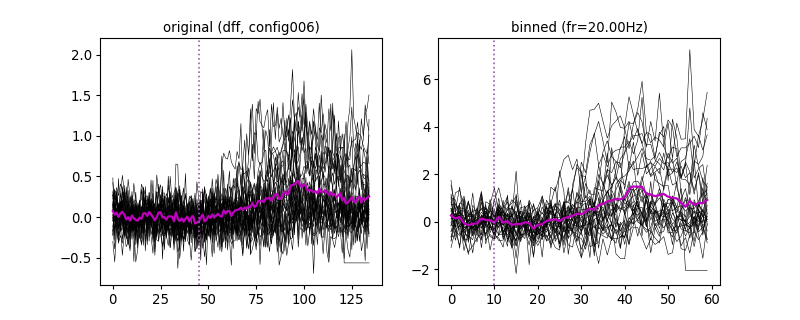

In [74]:
fig, axn = pl.subplots(1, 2, figsize=(10,4))
ax=axn[0]; ax.set_title('original (%s, %s)' % (response_type, cfg));
ax.plot(trialmat.loc[trial_ixs].values.T, 'k', lw=0.5)
ax.plot(np.nanmean(trialmat.loc[trial_ixs].values.T, axis=1), 'm', lw=2)
ax.axvline(x=stim_on, ls=':')


ax=axn[1]; ax.set_title('binned (fr=%.2fHz)' % (face_framerate));
ax.plot(binned_trialmat.T, 'k', lw=0.5)
ax.plot(np.nanmean(binned_trialmat, axis=0), 'm', lw=2)
ax.axvline(x=new_stim_on, ls=':')

# ax=axn[2]; ax.set_title('zscored');
# ax.plot(curr_roi_traces.loc[trial_ixs].values.T, 'k', lw=0.5)
# ax.plot(np.nanmean(curr_roi_traces.loc[trial_ixs].values.T, axis=0), 'm', lw=2)
# ax.axvline(x=new_stim_on, ls=':')
# pl.subplots_adjust(top=0.8)
# pl.suptitle('rid %i' % rid)


### (Example) Match pupil framerate

#### Resample pupil

In [43]:
iti_pre_ms

500.0

In [44]:
trial_epoch='pre'
face_feature='pupil_area'

#### Resample pupil
binned_pupil = bin_pupil_traces(pupiltraces, feature_name=face_feature,
                                     in_rate=face_framerate, out_rate=face_framerate, 
                                     min_nframes=desired_nframes, iti_pre_ms=iti_pre_ms)
new_stim_on = binned_pupil['stim_on'].unique()[0]
print("New stimulus on: %i" % new_stim_on)
pupil_r = resample_pupil_traces(pupiltraces, in_rate=face_framerate, out_rate=face_framerate, 
                               desired_nframes=desired_nframes, feature_name=face_feature, 
                               iti_pre_ms=iti_pre_ms)
pupildf = get_pupil_df(pupil_r, trial_epoch=trial_epoch, new_stim_on=new_stim_on)

#### Make sure neural df matches
neuraldf=neuraldf.loc[trials_with_pupil]

#### Filter out trials with no pupil info or no neural
neuraldf, pupiltraces = match_trials(neuraldf, pupiltraces, labels_all)

New stimulus on: 10


<IPython.core.display.Javascript object>


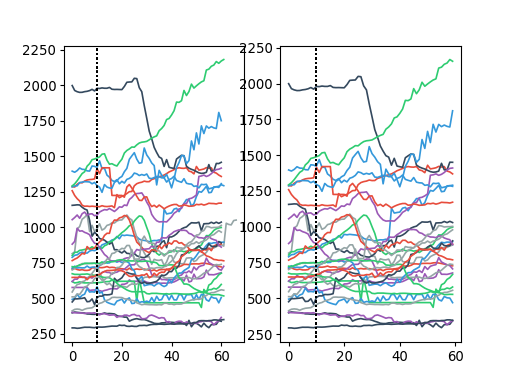

In [45]:
fig, axn = pl.subplots(1, 2)
ax=axn[0]
for t, pg in pupiltraces[pupiltraces['config']==cfg].groupby(['trial']):
    ixs = np.arange(0, len(pg[face_feature].values))
    ax.plot(ixs, pg[face_feature].values)
    ax.axvline(x=new_stim_on, ls=':', color='k')
    
ax=axn[1]
for t, pg in binned_pupil[binned_pupil['config']==cfg].groupby(['trial']):
    ixs = np.arange(0, len(pg[face_feature].values))
    ax.plot(ixs, pg[face_feature].values)
    ax.axvline(x=new_stim_on, ls=':', color='k')

In [65]:
binned_trialmat.shape

(30, 60)

In [66]:
#### Create trialmat for selected trials (pupil)
pupil_trialmat = pd.DataFrame(np.vstack([p[face_feature].values 
                                         for trial, p in binned_pupil.groupby(['trial'])]),
                              index=trialmat.index)
print(pupil_trialmat.shape)


(1500, 60)


<IPython.core.display.Javascript object>


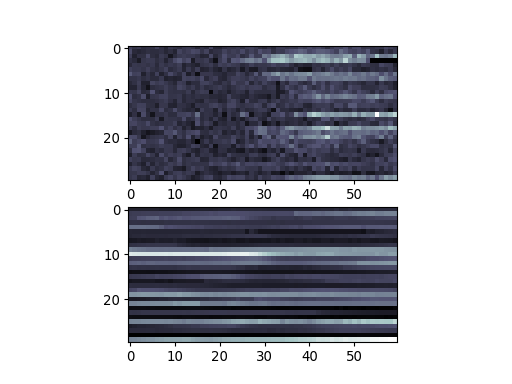

In [75]:
fig, axn = pl.subplots(2, 1)
ax=axn[0]
ax.imshow(binned_trialmat.loc[trial_ixs], cmap='bone')
ax=axn[1]
ax.imshow(pupil_trialmat.loc[trial_ixs], cmap='bone')


### (Example) Get all rois and traces

In [76]:
n_processes=1

# df_split = np.array_split(traces[curr_rois].T, n_processes)

In [103]:
if n_processes>1:
    traces_r = resample_roi_traces_mp(traces[curr_rois], labels=labels, in_rate=framerate, 
                                      out_rate=face_framerate, n_processes=n_processes)
else:
    traces_r = pd.concat([resample_neural_traces(traces[x], labels, in_rate=framerate, out_rate=face_framerate, 
                                            zscore=True, return_labels=False) for x in roi_list], axis=1)

KeyboardInterrupt: 

In [104]:
# Get labels
labels_r = resample_labels(labels, in_rate=framerate, out_rate=face_framerate)

135 frames/trial


In [124]:
### Get resampled indices of trial epochs
#traces_r = resample_all_roi_traces(traces, labels, in_rate=framerate, out_rate=face_framerate)



# Create data frames for pupil/neural data - test low/high pupil

In [105]:
n_cuts=3

# ------ Split trials by quantiles ---------------------------------
quantile_bins, pupil_low, pupil_high = split_pupil_range(pupildf, feature_name=face_feature, 
                                                           n_cuts=n_cuts, return_bins=True)
# Get quantile values
pupil_quantiles = pupildf[face_feature].quantile(quantile_bins)

# Can also bin into low, mid, high for visualization
pupildf['quantile'] = pd.qcut(pupildf[face_feature], n_cuts, labels=False)

In [106]:
pupil_quantiles

0.333333    595.879857
0.666667    925.414434
Name: pupil_area, dtype: float64

## Subdivide pupil levels into high/low

<IPython.core.display.Javascript object>


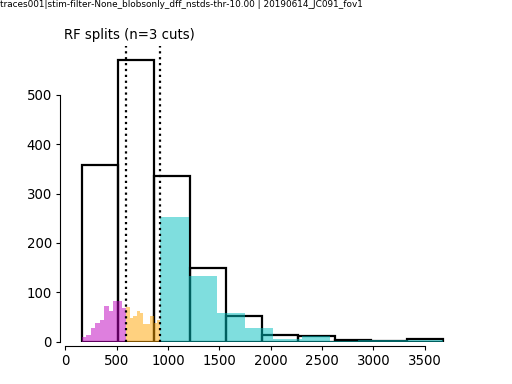

In [107]:

fig, ax = pl.subplots()
ax.hist(pupildf[face_feature], edgecolor='k', facecolor='none', lw=2)
for v in pupil_quantiles:
    ax.axvline(x=v, ls=':', color='k', lw=2)
    
qcolors = ['m', 'orange', 'c', 'b']
for col, (i, pg) in zip(qcolors, pupildf.groupby(['quantile'])):
    ax.hist(pg[face_feature].values, color=col, alpha=0.5)
    
    
sns.despine(trim=True, offset=4)
ax.set_title('RF splits (n=%i cuts)' % n_cuts, loc='left')
putils.label_figure(fig, '%s | %s' % (data_id, datakey))

# Decode classes, split arousal state

In [42]:
import random
import scipy.stats as spstats
import sklearn.metrics as skmetrics

from sklearn.model_selection import train_test_split, cross_validate, KFold, learning_curve, ShuffleSplit
from sklearn.svm import LinearSVC
#from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler


In [43]:
from pipeline.python.classifications import decode_utils as dec

In [44]:
reload(dec)

<module 'pipeline.python.classifications.decode_utils' from '/home/julianarhee/Repositories/2p-pipeline/pipeline/python/classifications/decode_utils.pyc'>

In [45]:
def fit_classifier_bootstrap(curr_data, sdf, m0=0, m100=106, cv_nfolds=5, test_size=0.2, C_value=1.0, n_iterations=100):
    iter_list=[]; chance_list=[];
    for iteration in np.arange(0, n_iterations):

        #### Select train/test configs for clf A vs B
        object_configs = sdf[sdf['morphlevel'].isin([m0, m100])].index.tolist() 
        curr_roi_list = [int(c) for c in curr_data.columns if c != 'config']
        sample_data = curr_data[curr_data['config'].isin(object_configs)]

        #### Equalize df/f across neurons:  Normalize each neuron to have same (zero) mean, (unit) SD across stimuli
        data = sample_data[curr_roi_list]
        zdata = (data - data.mean()) / data.std()

        #### Get labels
        targets = pd.DataFrame(sample_data['config'].copy(), columns=['config'])
        targets['label'] = [sdf['morphlevel'][cfg] for cfg in targets['config'].values]
        targets['group'] = [sdf['size'][cfg] for cfg in targets['config'].values]
        
        #### Fit
        curr_iter, curr_iter_chance = dec.fit_svm_shuffle(zdata, targets, C_value=C_value, test_split=test_size)
        
        #### Add
        iter_list.append(pd.DataFrame(curr_iter, index=[iteration]))
        chance_list.append(pd.DataFrame(curr_iter_chance, index=[iteration]))
        
    # DATA - get mean across iters
    iter_results = pd.concat(iter_list, axis=0)
    iterdict = dict(iter_results.mean())
    iterdict.update( dict(('%s_std' % k, v) for k, v in \
                          zip(iter_results.std().index, iter_results.std().values)) )
    iterdict.update( dict(('%s_sem' % k, v) for k, v in \
                          zip(iter_results.sem().index, iter_results.sem().values)) )


    # CHANCE - get mean across iters
    iter_results_chance = pd.concat(chance_list, axis=0)
    iterdict_chance = dict(iter_results_chance.mean())
    iterdict_chance.update( dict(('%s_std' % k, v) for k, v in \
                          zip(iter_results_chance.std().index, iter_results_chance.std().values)) )
    iterdict_chance.update( dict(('%s_sem' % k, v) for k, v in \
                          zip(iter_results_chance.sem().index, iter_results_chance.sem().values)) )
    
    iterdict.update({'class_a': m0, 'class_b': m100})
    iterdict_chance.update({'class_a': m0, 'class_b': m100})
      
    return iterdict, iterdict_chance # df, df_chance


In [46]:
x=None
y = x is None
print(y)

True


# Set output dir for decoding w.r.t. behavior state

In [47]:
decoding_dir = os.path.join(aggregate_dir, 'behavior-state', 'decoding')
if not os.path.exists(decoding_dir):
    os.makedirs(decoding_dir)
print(decoding_dir)

/n/coxfs01/julianarhee/aggregate-visual-areas/behavior-state/decoding


In [147]:
# Get trial indices of low/high pupil 
low_trial_ixs = sorted(pupil_low['trial'].unique())
high_trial_ixs = sorted(pupil_high['trial'].unique())

print(pupil_low.shape, pupil_high.shape)


((500, 6), (500, 6))


In [148]:
m0=0
m100=106
C_value=1

n_iterations = 50
test_size=0.2
cv_nfolds=5

In [149]:
# Fit ALL
#curr_data = neuraldf.copy()
all_trial_ixs = neuraldf.index.tolist()

i=0
d_list=[]
shuf_list = []
for arousal, curr_trial_ixs in zip(['all', 'low', 'high'], [all_trial_ixs, low_trial_ixs, high_trial_ixs]):
    curr_data = neuraldf.loc[curr_trial_ixs].copy()
    iterdict, iterdict_chance = fit_classifier_bootstrap(curr_data, sdf, m0=m0, m100=m100, n_iterations=n_iterations,
                                  cv_nfolds=cv_nfolds, test_size=test_size, C_value=C_value)

    iterdict['arousal'] = arousal
    iterdict_chance['arousal'] = arousal
    #df['arousal'] = [arousal for _ in np.arange(0, len(df))]
    #df_chance['arousal'] = [arousal for _ in np.arange(0, len(df))]

    d_list.append(pd.DataFrame(iterdict, index=[i])) #df)
    shuf_list.append(pd.DataFrame(iterdict_chance, index=[i])) #df_chance)
                     
    i+=1

df = pd.concat(d_list, axis=0)
df_chance = pd.concat(shuf_list, axis=0)

print(df.shape, d_list[0].shape)

((3, 39), (1, 39))


In [150]:
df

,arousal,class_a,class_b,fit_time,fit_time_sem,fit_time_std,heldout_MI,heldout_MI_sem,heldout_MI_std,heldout_aMI,...,test_r2_std,train_accuracy,train_accuracy_sem,train_accuracy_std,train_neg_mean_squared_error,train_neg_mean_squared_error_sem,train_neg_mean_squared_error_std,train_r2,train_r2_sem,train_r2_std
0,all,0,106,0.012026,0.000050,0.000352,0.139348,0.006645,0.046985,0.191776,...,0.119222,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
1,low,0,106,0.002554,0.000006,0.000040,0.066151,0.007640,0.054025,0.068482,...,0.176102,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
2,high,0,106,0.001184,0.000003,0.000022,0.128959,0.015871,0.112223,0.144826,...,0.204732,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0


## Fit all morph pairs

In [151]:
morphs= [m for m in sdf['morphlevel'].unique() if m!=-1]
morph_pairs = list(itertools.combinations(morphs, 2))

# score_metrics = ['train_accuracy', 'test_accuracy', 'heldout_test_score', 'heldout_log2MI', 'heldout_aMI', 'heldout_MI']

# Fit ALL
all_trial_ixs = neuraldf.index.tolist()

d_list=[]
shuf_list = []
for (m0, m100) in morph_pairs:
    for arousal, curr_trial_ixs in zip(['all', 'low', 'high'], [all_trial_ixs, low_trial_ixs, high_trial_ixs]):
        curr_data = neuraldf.loc[curr_trial_ixs].copy()
        iterdict, iterdict_chance = fit_classifier_bootstrap(curr_data, sdf, m0=m0, m100=m100, n_iterations=n_iterations,
                                      cv_nfolds=cv_nfolds, test_size=test_size, C_value=C_value)

        iterdict['arousal'] = arousal
        iterdict_chance['arousal'] = arousal
        #df['arousal'] = [arousal for _ in np.arange(0, len(df))]
        #df_chance['arousal'] = [arousal for _ in np.arange(0, len(df))]

        d_list.append(pd.DataFrame(iterdict, index=[i])) #df)
        shuf_list.append(pd.DataFrame(iterdict_chance, index=[i])) #df_chance)

        i+=1

df = pd.concat(d_list, axis=0)
df_chance = pd.concat(shuf_list, axis=0)

df['class_diff'] = abs(df['class_a'] - df['class_b'])
df_chance['class_diff'] = abs(df['class_a'] - df['class_b'])

In [152]:
report_metric = 'heldout_test_score'
for arousal, ag in df[(df['class_a']==0) & (df['class_b']==106)].groupby(['arousal']):
    ch = df_chance[(df_chance['class_a']==0) & (df_chance['class_b']==106) & (df_chance['arousal']==arousal)].copy()
    print('%s: %.2f (chance=%.2f)' % (arousal, ag.mean()[report_metric], ch.mean()[report_metric]))

all: 0.75 (chance=0.51)
high: 0.70 (chance=0.52)
low: 0.64 (chance=0.51)


<IPython.core.display.Javascript object>


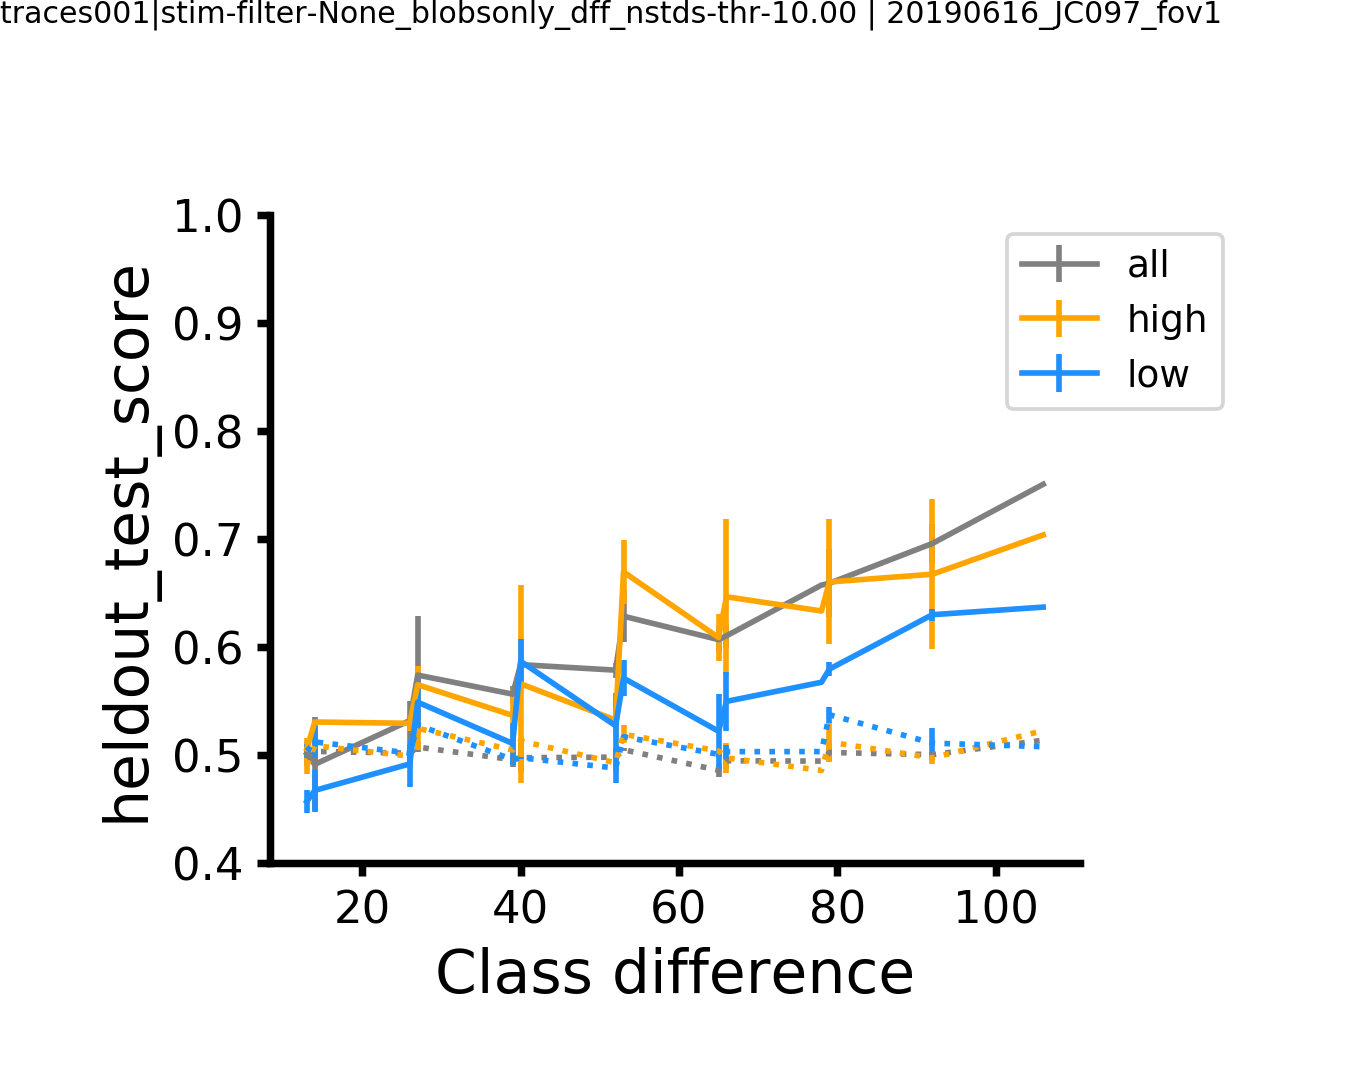

('/n/coxfs01/julianarhee/aggregate-visual-areas/behavior-state/decoding', 'heldout_test_score_by_class_diff_ex-20190616_JC097_fov1_split-colors')


In [153]:
report_metric='heldout_test_score'

fig, ax = pl.subplots(sharex=True, sharey=True, figsize=(5,4), dpi=dpi)

arousal_colors=['gray', 'orange', 'dodgerblue']

for col, (arousal, ag) in zip(arousal_colors, df.groupby(['arousal'])):
    xx = ag.groupby(['class_diff']).mean()[report_metric].index.tolist()
    yy = ag.groupby(['class_diff']).mean()[report_metric].values
    sem_yy = ag.groupby(['class_diff']).sem()[report_metric].values
    ax.errorbar(xx, yy, yerr=sem_yy, color=col, label=arousal)
    
    ch = df_chance[df_chance['arousal']==arousal]
    yy = ch.groupby(['class_diff']).mean()[report_metric].values
    xx = ch.groupby(['class_diff']).mean()[report_metric].index.tolist()
    sem_yy = ch.groupby(['class_diff']).sem()[report_metric].values
    ax.errorbar(xx, yy, yerr=sem_yy, color=col, ls=':', label=None)
    
ax.set_xlabel('Class difference')
ax.set_ylabel(report_metric)

ax.set_ylim([0.4, 1])
ax.legend(bbox_to_anchor=(1.2, 1))
putils.label_figure(fig, '%s | %s' % (data_id, datakey))
pl.subplots_adjust(left=0.2, bottom=0.2, top=0.8, right=0.8)
sns.despine()

figname = '%s_by_class_diff_ex-%s_split-colors' % (report_metric, datakey)
pl.savefig(os.path.join(decoding_dir, '%s.svg' % figname))
print(decoding_dir, figname)

In [209]:
decoding_dir

'/n/coxfs01/julianarhee/aggregate-visual-areas/behavior-state/decoding'

In [260]:
# # Calculate face feature
# # ----------------------------------------------------------
# face_feature = 'pupil_area'
# #------------------------------------------------------------

# for dkey in curr_dsets['datakey'].unique():

#     print("[%s] getting extracted feature: %s" % (dkey, face_feature))
#     session, animalid, fov = dkey.split('_')
#     fovnum = int(fov[3:])
#     fov = 'FOV%i_zoom2p0x' % fovnum

#     #### Get labels
#     labels_dfile = glob.glob(os.path.join(rootdir, animalid, session, fov, 'combined_*%s*' % experiment, 'traces',
#                           '%s*' % traceid, 'data_arrays', 'labels.npz'))[0]
#     l = np.load(labels_dfile)
#     labels = pd.DataFrame(data=l['labels_data'], columns=l['labels_columns'])

#     #### Load pupil data
#     facemeta, pupildata = dlcutils.load_pose_data(animalid, session, fovnum, experiment, dlc_results_dir, 
#                                                   feature_list=[face_feature], epoch='trial_alignment', 
#                                                   pre_ITI_ms=iti_pre_ms, post_ITI_ms=iti_post_ms)

#     #### Parse pupil data into traces
#     pupiltraces = dlcutils.get_pose_traces(facemeta, pupildata, labels, feature=face_feature)

#     #### Add to dict
#     datakey ='%s_%s_fov%i_%s' % (session, animalid, fovnum, experiment)  
#     PUPIL[datakey] = pupiltraces


# # This is a dict, keys are datakeys
# with open(pupil_fpath, 'wb') as f:
#     pkl.dump(PUPIL, f, protocol=pkl.HIGHEST_PROTOCOL)


[20190502_JC076_fov1] getting extracted feature: pupil_area
Loading pose data (dlc)
('[blobs] Found runs:', ['1', '2', '3', '4', '5', '6'])
... finding movies for dset: 20190502_JC076_fov1_blobs
(0, '/n/coxfs01/2p-data/eyetracker_tmp/20190502_JC076_fov1_blobs_f1_20190502161157200591')
(1, '/n/coxfs01/2p-data/eyetracker_tmp/20190502_JC076_fov1_blobs_f2_20190502165806929905')
(2, '/n/coxfs01/2p-data/eyetracker_tmp/20190502_JC076_fov1_blobs_f3_20190502173703971093')
(3, '/n/coxfs01/2p-data/eyetracker_tmp/20190502_JC076_fov1_blobs_f4_20190502182003125103')
(4, '/n/coxfs01/2p-data/eyetracker_tmp/20190502_JC076_fov1_blobs_f4b_20190502183313065375')
(5, '/n/coxfs01/2p-data/eyetracker_tmp/20190502_JC076_fov1_blobs_f4b_20190502183351360255')
(6, '/n/coxfs01/2p-data/eyetracker_tmp/20190502_JC076_fov1_blobs_f4c_20190502183919522127')
(7, '/n/coxfs01/2p-data/eyetracker_tmp/20190502_JC076_fov1_blobs_f6_20190502195321083042')
----- File 1.-----
... Eyetracker dir: 20190502_JC076_fov1_blobs_f1_201905

Traceback (most recent call last):
  File "/net/coxfs01/srv/export/coxfs01/share_root/2p-pipeline/repos/2p-pipeline/pipeline/python/classifications/dlc_utils.py", line 391, in align_trials_to_facedata
    curr_face_srcdir = [s for s in facetracker_srcdirs if '_f%s_' % run_num in s][0]
IndexError: list index out of range


Getting pose metrics by trial
... found 3 DLC outfiles, expecting 8 based on found eyetracker dirs.
...curr run: 1 [20190502_JC076_fov1_blobs_f1DLC_resnet50_facetrackingJan25shuffle1_391800.h5]
...curr run: 2 [20190502_JC076_fov1_blobs_f2DLC_resnet50_facetrackingJan25shuffle1_391800.h5]
...curr run: 3 [20190502_JC076_fov1_blobs_f3DLC_resnet50_facetrackingJan25shuffle1_391800.h5]
... done parsing!
Parsing pose data with MW
Missing 625 trials total
[20190605_JC090_fov1] getting extracted feature: pupil_area
Loading pose data (dlc)
('[blobs] Found runs:', ['1', '2', '3', '4', '5', '6', '7'])
... finding movies for dset: 20190605_JC090_fov1_blobs
(0, '/n/coxfs01/2p-data/eyetracker_tmp/20190605_JC090_fov1_blobs_f1_20190605141933120131')
(1, '/n/coxfs01/2p-data/eyetracker_tmp/20190605_JC090_fov1_blobs_f2_20190605151304470267')
(2, '/n/coxfs01/2p-data/eyetracker_tmp/20190605_JC090_fov1_blobs_f3_20190605160757630689')
(3, '/n/coxfs01/2p-data/eyetracker_tmp/20190605_JC090_fov1_blobs_f4_20190605

Loading pose data (dlc)
('[blobs] Found runs:', ['1', '2', '3', '4', '5', '6'])
... finding movies for dset: 20190609_JC099_fov1_blobs
(0, '/n/coxfs01/2p-data/eyetracker_tmp/20190609_JC099_fov1_blobs_f1_20190609111435073145')
(1, '/n/coxfs01/2p-data/eyetracker_tmp/20190609_JC099_fov1_blobs_f2_20190609120626917118')
(2, '/n/coxfs01/2p-data/eyetracker_tmp/20190609_JC099_fov1_blobs_f3_20190609131907762511')
(3, '/n/coxfs01/2p-data/eyetracker_tmp/20190609_JC099_fov1_blobs_f4_20190609142912202443')
(4, '/n/coxfs01/2p-data/eyetracker_tmp/20190609_JC099_fov1_blobs_f5_20190609154127271261')
(5, '/n/coxfs01/2p-data/eyetracker_tmp/20190609_JC099_fov1_blobs_f6_20190609155730800664')
----- File 1.-----
... Eyetracker dir: 20190609_JC099_fov1_blobs_f1_20190609111435073145
... found 2 funky frame chunks: [8879, 12579]
... Full run duration: 14.10 min
----- File 2.-----
... Eyetracker dir: 20190609_JC099_fov1_blobs_f2_20190609120626917118
... found 5 funky frame chunks: [3959, 10439, 13475, 15059, 15

...curr run: 10 [20191018_JC113_fov1_blobs_f10DLC_resnet50_facetrackingJan25shuffle1_391800.h5]
...curr run: 11 [20191018_JC113_fov1_blobs_f11DLC_resnet50_facetrackingJan25shuffle1_391800.h5]
...curr run: 12 [20191018_JC113_fov1_blobs_f12DLC_resnet50_facetrackingJan25shuffle1_391800.h5]
... done parsing!
Parsing pose data with MW
Missing 0 trials total
[20191105_JC117_fov1] getting extracted feature: pupil_area
Loading pose data (dlc)
('[blobs] Found runs:', ['1', '2', '3', '4', '5', '6'])
... finding movies for dset: 20191105_JC117_fov1_blobs
(0, '/n/coxfs01/2p-data/eyetracker_tmp/20191105_JC117_fov1_blobs_f1_20191105114840149566')
(1, '/n/coxfs01/2p-data/eyetracker_tmp/20191105_JC117_fov1_blobs_f2_20191105120405410749')
(2, '/n/coxfs01/2p-data/eyetracker_tmp/20191105_JC117_fov1_blobs_f3_20191105132317902204')
(3, '/n/coxfs01/2p-data/eyetracker_tmp/20191105_JC117_fov1_blobs_f4_20191105134239875931')
(4, '/n/coxfs01/2p-data/eyetracker_tmp/20191105_JC117_fov1_blobs_f5_201911051430137572

# Decode

In [48]:
# Temporal binning params
new_framerate = 20.0
framerate = 44.65

#### Get trial epochs
stim_on = float(labels['stim_on_frame'].unique())
n_on = float(labels['nframes_on'].unique())
new_stim_on = int(np.where(abs(out_ixs-stim_on) == min(abs(out_ixs-stim_on)))[0])
print(stim_on, new_stim_on)
stim_dur = stim_on/framerate
new_n_on = int(round( stim_dur*new_framerate))
print(new_n_on)

NameError: name 'labels' is not defined

In [132]:

use_pre_stimulus=True
# Get mean of pupil during trial - select PRE or PERI stimulus, for ex.
print("Stim on (new fr): %i" % new_stim_on)


Stim on (new fr): 20


# decode at 1 c

In [56]:
reload(dec)

<module 'pipeline.python.classifications.decode_utils' from '/home/julianarhee/Repositories/2p-pipeline/pipeline/python/classifications/decode_utils.pyc'>

In [65]:

face_feature='pupil_fraction'
iti_pre=1.0

pupil_epoch='pre'
face_framerate=20.
new_stim_on = int(iti_pre*face_framerate)
desired_nframes = 60 #len(out_ixs) # 60
segmented_datasets = cells['datakey'].unique()
print(new_stim_on)

20


In [66]:
use_quartiles = False
n_cuts = 4 if use_quartiles else 3
min_ncells = 5

# Classifier params
m0=0
m100=106
C_value=1

cv_nfolds=5
test_size=0.2
n_iterations = 50
report_metric = 'heldout_test_score'
skip = [] # ['20190502_JC076_fov1'] # ['20190420_JC076_fov1']

need_to_segment=[]
need_to_realign=[]

d_list=[]; d_list_chance=[]; 
n_datakeys = len(dsets['datakey'].unique())
for di, ((visual_area, datakey), ds) in enumerate(dsets.groupby(['visual_area', 'datakey'])):
    if datakey not in segmented_datasets:
        need_to_segment.append(datakey)
        continue
    if datakey not in aligned_keys:
        need_to_realign.append(datakey)
        continue
        
    if di % 5 == 0:
        print("%i of %i datakeys" % (int(di+1), n_datakeys))
        
    print("----- %s | %s -----" % (visual_area, datakey))
    # ------ STIMULUS INFO -----------------------------------------
    session, animalid, fov_ = datakey.split('_')
    fovnum = int(fov_[3:])
    obj = util.Objects(animalid, session, 'FOV%i_zoom2p0x' %  fovnum, traceid=traceid)
    sdf = obj.get_stimuli()
    
    #### Get neural means
    neuraldf = aggr.get_neuraldf_for_cells_in_area(cells, MEANS, 
                                                   datakey=datakey, visual_area=visual_area) # MEANS[datakey].copy() 
    print("... n=%i cells" % int(neuraldf.shape[1]-1))
    if neuraldf.shape[1]<min_ncells:
        continue
        
    #### Resample pupil
    pupiltraces = PUPIL['%s_%s' % (datakey, experiment)].copy()
    pupil_r = resample_pupil_traces(pupiltraces, in_rate=face_framerate, out_rate=new_framerate, 
                                   desired_nframes=desired_nframes, feature_name=face_feature, 
                                   iti_pre_ms=iti_pre_ms)
    pupildf = get_pupil_df(pupil_r, trial_epoch=pupil_epoch, new_stim_on=new_stim_on)
    
    #### Make sure neural df matches
    trials_with_pupil = list(pupildf['trial'].unique())
    neuraldf=neuraldf.loc[trials_with_pupil]

    #### Filter out trials with no pupil info or no neural
    neuraldf, pupiltraces = match_trials(neuraldf, pupiltraces, labels_all)
    
    # ------ Split trials by quantiles ---------------------------------
    pupil_low, pupil_high = split_pupil_range(pupildf, feature_name=face_feature, n_cuts=n_cuts)

    # Get trial indices of low/high pupil 
    low_trial_ixs = pupil_low['trial'].unique()
    high_trial_ixs = pupil_high['trial'].unique()
    all_trial_ixs = pupildf['trial'].unique()
    
    # Fit ALL
    tmp_d_list=[]; tmp_shuf_list=[];
    i=0
    for arousal, curr_trial_ixs in zip(['all', 'low', 'high'], [all_trial_ixs, low_trial_ixs, high_trial_ixs]):
        curr_data = neuraldf.loc[curr_trial_ixs].copy()
        iterdict, iterdict_chance = fit_classifier_bootstrap(curr_data, sdf, m0=m0, m100=m100, n_iterations=n_iterations,
                                      cv_nfolds=cv_nfolds, test_size=test_size, C_value=C_value)

        iterdict['arousal'] = arousal
        iterdict_chance['arousal'] = arousal
        tmp_d_list.append(pd.DataFrame(iterdict, index=[i])) #df)
        tmp_shuf_list.append(pd.DataFrame(iterdict_chance, index=[i])) #df_chance)
        print("...%s: %.2f (chance=%.2f)" % (arousal, iterdict[report_metric], iterdict_chance[report_metric]))
        
        i+=1
        
    tmp_df = pd.concat(tmp_d_list, axis=0)
    metadict = {'visual_area': visual_area, 'datakey': datakey, 'n_cells': int(neuraldf.shape[1]-1)}
    tmp_df = putils.add_meta_to_df(tmp_df, metadict)
    # print(tmp_df.shape)
    tmp_chance = pd.concat(tmp_shuf_list, axis=0)
    tmp_chance = putils.add_meta_to_df(tmp_chance, metadict)
    
    d_list.append(tmp_df)
    d_list_chance.append(tmp_chance)

df = pd.concat(d_list, axis=0)
df_chance = pd.concat(d_list_chance, axis=0)

1 of 35 datakeys
----- Li | 20190502_JC076_fov1 -----
... n=0 cells
----- Li | 20190602_JC091_fov1 -----
... n=136 cells


NameError: name 'labels_all' is not defined

In [215]:
min_ncells=20

too_few_cells = df[df['n_cells']<min_ncells]['datakey'].unique()
print(too_few_cells)

['20191111_JC120_fov1']


In [223]:
avg_test = df.groupby(['visual_area', 'datakey']).mean()['test_accuracy'].reset_index()


avg_test_chance = df_chance.groupby(['visual_area', 'datakey']).mean()['test_accuracy'].reset_index()
avg_test_chance.rename(columns={'test_accuracy': 'chance_accuracy'}, inplace=True)


avg_results = pd.merge(avg_test, avg_test_chance)

In [224]:
poor_performance = [dk for (v, dk), g in avg_results.groupby(['visual_area', 'datakey'])\
                        if g['test_accuracy'].values<g['chance_accuracy'].values 
                           or g['test_accuracy'].values < 0.5]
print(poor_performance)

['20190607_JC091_fov1', '20191018_JC113_fov1']


In [231]:
dst_dir = os.path.join(decoding_dir, 'pupil', 'by_fov')
if not os.path.exists(dst_dir):
    print(dst_dir)
    os.makedirs(dst_dir)

/n/coxfs01/julianarhee/aggregate-visual-areas/behavior-state/decoding/pupil/by_fov


<IPython.core.display.Javascript object>


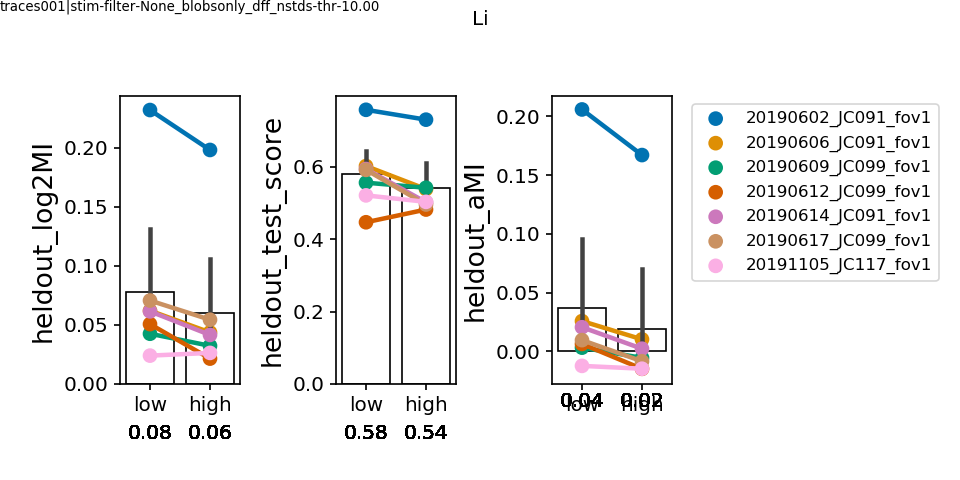

STATS - Li
heldout_log2MI--------------------
Paired t-test, t=3.98 (p=0.01)
heldout_test_score--------------------
Paired t-test, t=2.21 (p=0.07)
heldout_aMI--------------------
Paired t-test, t=4.08 (p=0.01)
('/n/coxfs01/julianarhee/aggregate-visual-areas/behavior-state/decoding/pupil/by_fov', 'pupil_area_Li_morph0v106_C-1.00_50-iters')


<IPython.core.display.Javascript object>


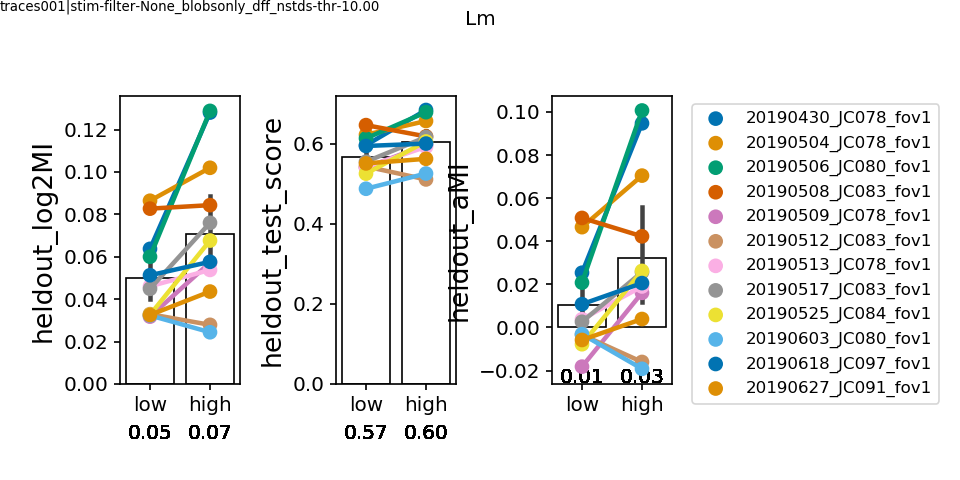

STATS - Lm
heldout_log2MI--------------------
Paired t-test, t=-2.93 (p=0.01)
heldout_test_score--------------------
Paired t-test, t=-3.16 (p=0.01)
heldout_aMI--------------------
Paired t-test, t=-2.53 (p=0.03)
('/n/coxfs01/julianarhee/aggregate-visual-areas/behavior-state/decoding/pupil/by_fov', 'pupil_area_Lm_morph0v106_C-1.00_50-iters')


<IPython.core.display.Javascript object>


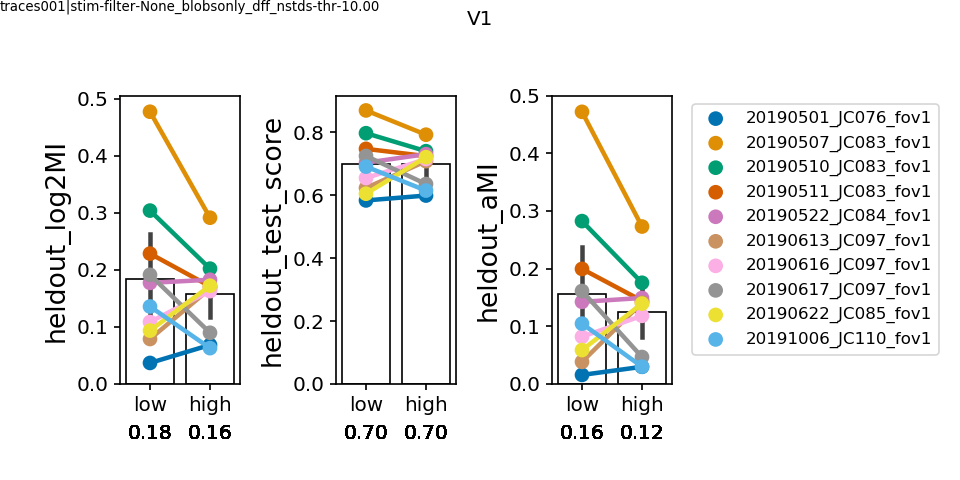

STATS - V1
heldout_log2MI--------------------
Paired t-test, t=0.91 (p=0.39)
heldout_test_score--------------------
Paired t-test, t=0.08 (p=0.94)
heldout_aMI--------------------
Paired t-test, t=1.03 (p=0.33)
('/n/coxfs01/julianarhee/aggregate-visual-areas/behavior-state/decoding/pupil/by_fov', 'pupil_area_V1_morph0v106_C-1.00_50-iters')


In [235]:


skip = list(too_few_cells)
skip.extend(poor_performance) #['20190602_JC091_fov1', '20191105_JC117_fov1', '20191111_JC120_fov1']#'20190602_JC091_fov1', '20190502_JC076_fov1'

for visual_area, vdf in df.groupby(['visual_area']):

    plotdf = vdf[(~vdf['datakey'].isin(skip)) & (vdf['arousal'].isin(['low','high']))]
    metrics = ['heldout_log2MI', 'heldout_test_score', 'heldout_aMI']

    fig, axn = pl.subplots(1, 3, figsize=(8,4), dpi=dpi)
    for ai, (ax, metric) in enumerate(zip(axn.flat, metrics)):

        # Plot each fov
        sns.pointplot(x='arousal', y=metric, hue='datakey', data=plotdf, ax=ax, 
                      palette='colorblind', s=10, alpha=0.5)
        sns.barplot(x='arousal', y=metric, data=plotdf, ax=ax, 
                    edgecolor=('k', 'k', 'k'), facecolor=(1,1,1,0))
        plotdf.apply(aggr.annotateBars, ax=ax,fontsize=12, fontcolor='k', xytext=(0, -30))
        if ai<2:
            ax.legend_.remove()
        ax.set_xlabel('')

    ax.legend(bbox_to_anchor=(1.1, 1))
    pl.subplots_adjust(right=0.7, wspace=0.8, hspace=0.2, top=0.8, bottom=0.2)
    fig.suptitle(visual_area)
    
    #
    print("STATS - %s" % visual_area)
    metric = 'heldout_test_score'
    for metric in metrics:
        print('%s--------------------' % metric)
        a = plotdf[(plotdf['arousal']=='low')][metric]
        b = plotdf[(plotdf['arousal']=='high')][metric]
        tstat, pval = spstats.ttest_rel(a, b)
        print("Paired t-test, t=%.2f (p=%.2f)" % (tstat, pval))

    putils.label_figure(fig, data_id)
    C_str = 'C-%.2f' % C_value if C_value is not None else 'tuneC'
    figname = '%s_%s_morph%iv%i_%s_%i-iters' % (face_feature, visual_area, m0, m100, C_str, n_iterations)
    pl.savefig(os.path.join(dst_dir, '%s.svg' %figname))
    print(dst_dir, figname)

In [ ]:
skip = ['20190602_JC091_fov1', '20191105_JC117_fov1', '20191111_JC120_fov1']#'20190602_JC091_fov1', '20190502_JC076_fov1'

for visual_area, vdf in df.groupby(['visual_area']):

    plotdf = vdf[(~vdf['datakey'].isin(skip)) & (vdf['arousal'].isin(['low','high']))]
    metrics = ['heldout_log2MI', 'heldout_test_score', 'heldout_aMI']

    fig, axn = pl.subplots(1, 3, figsize=(10,4), dpi=dpi)
    for ai, (ax, metric) in enumerate(zip(axn.flat, metrics)):

        # Plot each fov
        sns.pointplot(x='arousal', y=metric, hue='datakey', data=plotdf, ax=ax, 
                      palette='colorblind', s=10, alpha=0.5)
        sns.barplot(x='arousal', y=metric, data=plotdf, ax=ax, 
                    edgecolor=('k', 'k', 'k'), facecolor=(1,1,1,0))
        plotdf.apply(aggr.annotateBars, ax=ax,fontsize=12, fontcolor='k', xytext=(0, -30))
        if ai<2:
            ax.legend_.remove()
        ax.set_xlabel('')

    ax.legend(bbox_to_anchor=(1.1, 1))
    pl.subplots_adjust(right=0.7, wspace=0.8, hspace=0.2, top=0.8, bottom=0.2)
    fig.suptitle(visual_area)
    
    #
    print("STATS - %s" % visual_area)
    metric = 'heldout_test_score'
    for metric in metrics:
        print('%s--------------------' % metric)
        a = plotdf[(plotdf['arousal']=='low')][metric]
        b = plotdf[(plotdf['arousal']=='high')][metric]
        tstat, pval = spstats.ttest_rel(a, b)
        print("Paired t-test, t=%.2f (p=%.2f)" % (tstat, pval))

    putils.label_figure(fig, data_id)
    figname = '%s_%s-test_%iv%i_C-%.2f, %i-iters' % (face_feature, visual_area, m0, m100, C_value, n_iterations)
    #pl.savefig(os.path.join(decoding_dir, '%s.svg' %figname))


In [113]:

metric = 'heldout_test_score'
for metric in metrics:
    print('%s--------------------' % metric)
    a = plotdf[(plotdf['arousal']=='low')][metric]
    b = plotdf[(plotdf['arousal']=='high')][metric]
    tstat, pval = spstats.ttest_rel(a, b)
    print("Paired t-test, t=%.2f (p=%.2f)" % (tstat, pval))

heldout_log2MI--------------------
Paired t-test, t=1.42 (p=0.21)
heldout_test_score--------------------
Paired t-test, t=3.57 (p=0.02)
heldout_aMI--------------------
Paired t-test, t=1.98 (p=0.10)


In [97]:
tstats, pval = spstats.ttest_rel(a, b)

In [108]:
cell_counts = pd.concat([pd.DataFrame({'visual_area':visual_area, 
                                       'datakey': datakey, 
                                       'n_cells': len(g['cell'])}, index=[i]) \
                    for i, ((visual_area, datakey), g) in enumerate(cells.groupby(['visual_area', 'datakey']))], axis=0)
cell_counts

,datakey,n_cells,visual_area
0,20190602_JC091_fov1,136,Li
1,20190606_JC091_fov1,82,Li
2,20190607_JC091_fov1,129,Li
3,20190609_JC099_fov1,71,Li
4,20190612_JC099_fov1,49,Li
5,20190614_JC091_fov1,129,Li
6,20190617_JC099_fov1,20,Li
7,20191105_JC117_fov1,60,Li
8,20191111_JC120_fov1,19,Li
9,20190603_JC080_fov1,190,Lm


In [105]:
cell_counts = pd.concat([pd.DataFrame({'visual_area':visual_area, 
                                       'datakey': datakey, 
                                       'n_cells': MEANS[datakey].shape[1]-1}, index=[i]) \
                    for i, ((visual_area, datakey), g) in enumerate(dsets.groupby(['visual_area', 'datakey']))], axis=0)
cell_counts

,datakey,n_cells,visual_area
0,20190502_JC076_fov1,150,Li
1,20190602_JC091_fov1,241,Li
2,20190605_JC090_fov1,129,Li
3,20190606_JC091_fov1,136,Li
4,20190607_JC091_fov1,260,Li
5,20190609_JC099_fov1,78,Li
6,20190612_JC099_fov1,95,Li
7,20190614_JC091_fov1,193,Li
8,20190617_JC099_fov1,25,Li
9,20191018_JC113_fov1,64,Li


In [108]:
decoding_dir

'/n/coxfs01/julianarhee/aggregate-visual-areas/behavior-state/decoding'

<IPython.core.display.Javascript object>


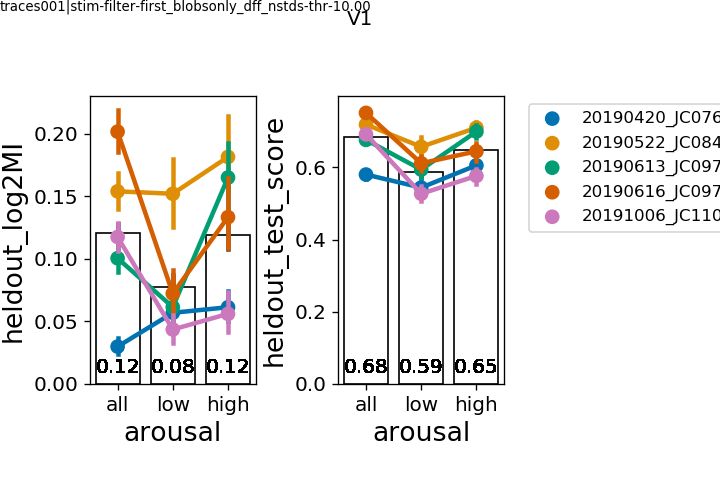

In [277]:
visual_area='V1'
if visual_area == 'V1':
    skip = ['20190507_JC083_fov1', '20190617_JC097_fov1', '20190622_JC085_fov1'] # fix eyetracker
elif visual_area == 'Li':
    skip = ['20190602_JC091_fov1', '20191018_JC113_fov1']
else:
    skip = []

plotdf = df[~df['datakey'].isin(skip)]

fig, axn = pl.subplots(1, 2, figsize=(6,4), dpi=dpi)
for ai, (ax, metric) in enumerate(zip(axn.flat, ['heldout_log2MI', 'heldout_test_score'])):


    # Plot each fov
    sns.pointplot(x='arousal', y=metric, hue='datakey', data=plotdf, ax=ax, 
                  palette='colorblind', s=10, alpha=0.5)
    sns.barplot(x='arousal', y=metric, data=plotdf, ax=ax, 
                edgecolor=('k', 'k', 'k'), facecolor=(1,1,1,0))
    plotdf.apply(aggr.annotateBars, ax=ax, axis=1, fontsize=12, fontcolor='k')
    if ai==0:
        ax.legend_.remove()
        
ax.legend(bbox_to_anchor=(1.1, 1))
pl.subplots_adjust(right=0.7, wspace=0.5, hspace=0.2, top=0.8, bottom=0.2)
fig.suptitle(visual_area)

putils.label_figure(fig, data_id)

figname = 'split_%s_%s-test_classify_%iv%i_C-%.2f, %i-iters' % (face_feature, visual_area, m0, m100, C_value, n_iterations)
pl.savefig(os.path.join(decoding_dir, '%s.svg' %figname))


#### snapshot 1

In [162]:
skip = ['20190420_JC076_fov1', '20190507_JC083_fov1', '20190617_JC097_fov1']

fig, axn = pl.subplots(1, 2, figsize=(12,4), dpi=dpi)
for ai, (ax, metric) in enumerate(zip(axn.flat, ['heldout_aMI', 'heldout_test_score'])):

    # Create dataframe
    m_ = pd.concat([full_df[[metric]], lo_df[metric], hi_df[metric]], axis=1)
    m_.columns = ['all', 'low', 'high']
    m_df = m_.unstack().reset_index().rename(columns={'level_0': 'arousal', 'level_1': 'datakey', 0: metric})
    m_df['datakey'] = [full_df.loc[i]['datakey'] for i in m_df['datakey']]
    m_df = m_df[~m_df['datakey'].isin(skip)]
    
    # Plot each fov
    sns.pointplot(x='arousal', y=metric, hue='datakey', data=m_df, ax=ax, 
                  palette='colorblind', s=10, alpha=0.5)
    sns.barplot(x='arousal', y=metric, data=m_df, ax=ax, 
                edgecolor=('k', 'k', 'k'), facecolor=(1,1,1,0))
    m_df.apply(aggr.annotateBars, ax=ax, axis=1, fontsize=12, fontcolor='k')
    if ai==0:
        ax.legend_.remove()
        
ax.legend(bbox_to_anchor=(1.1, 1))
pl.subplots_adjust(right=0.5, wspace=0.5, hspace=0.2, top=0.8, bottom=0.2)


figname = 'split_%s_%s-test_classify_%iv%i_C-%.2f, %i-iters' % (face_feature, visual_area, m0, m100, C_value, n_iterations)
pl.savefig(os.path.join(decoding_dir, '%s.svg' %figname))


<IPython.core.display.Javascript object>

NameError: name 'full_df' is not defined

#### snapshot 2

<IPython.core.display.Javascript object>


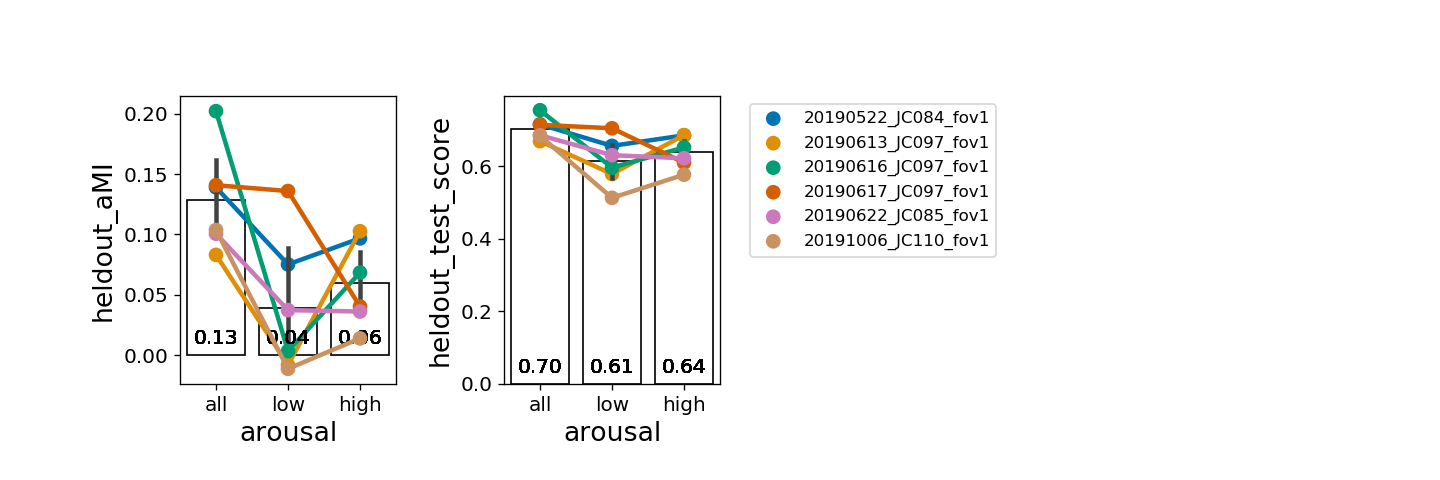

In [202]:
skip = ['20190420_JC076_fov1', '20190507_JC083_fov1']

fig, axn = pl.subplots(1, 2, figsize=(12,4), dpi=dpi)
for ai, (ax, metric) in enumerate(zip(axn.flat, ['heldout_aMI', 'heldout_test_score'])):

    # Create dataframe
    m_ = pd.concat([full_df[[metric]], lo_df[metric], hi_df[metric]], axis=1)
    m_.columns = ['all', 'low', 'high']
    m_df = m_.unstack().reset_index().rename(columns={'level_0': 'arousal', 'level_1': 'datakey', 0: metric})
    m_df['datakey'] = [full_df.loc[i]['datakey'] for i in m_df['datakey']]
    m_df = m_df[~m_df['datakey'].isin(skip)]
    
    # Plot each fov
    sns.pointplot(x='arousal', y=metric, hue='datakey', data=m_df, ax=ax, 
                  palette='colorblind', s=10, alpha=0.5)
    sns.barplot(x='arousal', y=metric, data=m_df, ax=ax, 
                edgecolor=('k', 'k', 'k'), facecolor=(1,1,1,0))
    m_df.apply(aggr.annotateBars, ax=ax, axis=1, fontsize=12, fontcolor='k')
    if ai==0:
        ax.legend_.remove()
        
ax.legend(bbox_to_anchor=(1.1, 1))
pl.subplots_adjust(right=0.5, wspace=0.5, hspace=0.2, top=0.8, bottom=0.2)

<IPython.core.display.Javascript object>


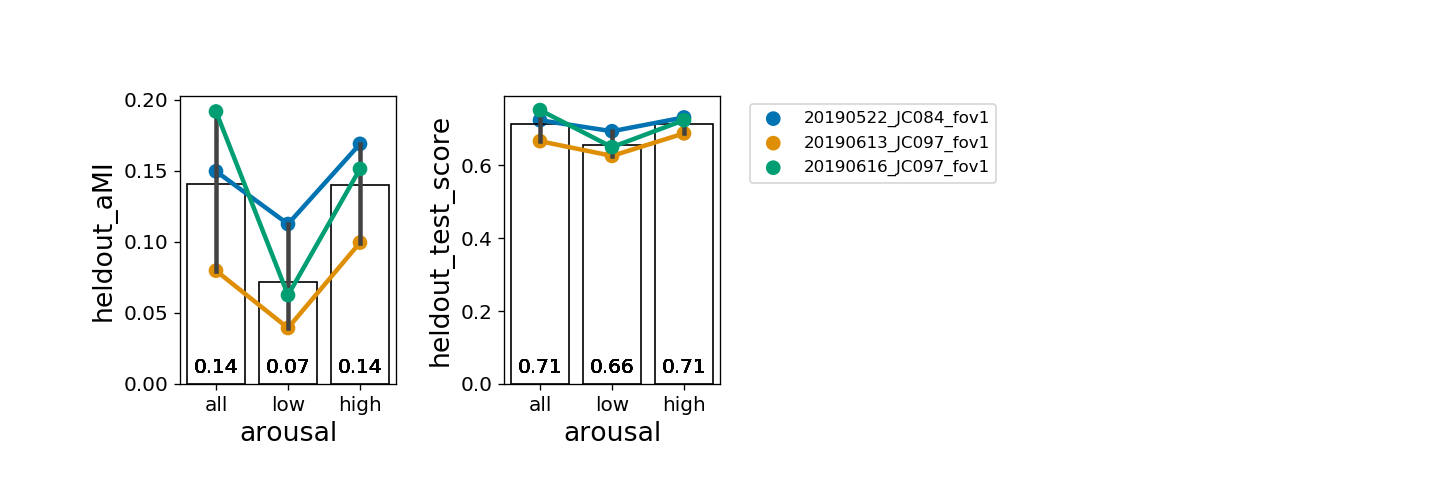

In [80]:
skip = ['20190420_JC076_fov1', '20190507_JC083_fov1']

fig, axn = pl.subplots(1, 2, figsize=(12,4), dpi=dpi)
for ai, (ax, metric) in enumerate(zip(axn.flat, ['heldout_aMI', 'heldout_test_score'])):

    # Create dataframe
    m_ = pd.concat([full_df[[metric]], lo_df[metric], hi_df[metric]], axis=1)
    m_.columns = ['all', 'low', 'high']
    m_df = m_.unstack().reset_index().rename(columns={'level_0': 'arousal', 'level_1': 'datakey', 0: metric})
    m_df['datakey'] = [full_df.loc[i]['datakey'] for i in m_df['datakey']]
    m_df = m_df[~m_df['datakey'].isin(skip)]
    
    # Plot each fov
    sns.pointplot(x='arousal', y=metric, hue='datakey', data=m_df, ax=ax, 
                  palette='colorblind', s=10)
    sns.barplot(x='arousal', y=metric, data=m_df, ax=ax, 
                edgecolor=('k', 'k', 'k'), facecolor=(1,1,1,0))
    m_df.apply(aggr.annotateBars, ax=ax, axis=1, fontsize=12, fontcolor='k')
    if ai==0:
        ax.legend_.remove()
        
ax.legend(bbox_to_anchor=(1.1, 1))
pl.subplots_adjust(right=0.5, wspace=0.5, hspace=0.2, top=0.8, bottom=0.2)

<IPython.core.display.Javascript object>


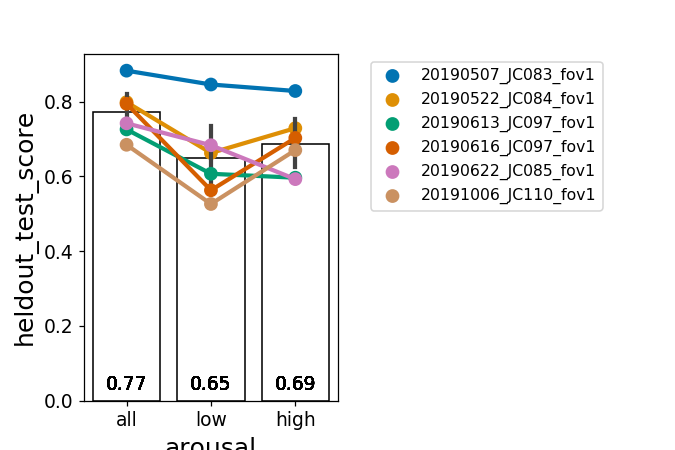

In [305]:
fig, ax = pl.subplots(figsize=(6,4), dpi=dpi)
sns.pointplot(x='arousal', y=metric, hue='datakey', data=m_df, ax=ax, palette='colorblind',
             s=10)
sns.barplot(x='arousal', y=metric, data=m_df, ax=ax, 
            edgecolor=('k', 'k', 'k'), facecolor=(1,1,1,0))
m_df.apply(aggr.annotateBars, ax=ax, axis=1, fontsize=12, fontcolor='k')
ax.legend(bbox_to_anchor=(1.1, 1))

pl.subplots_adjust(right=0.5)

In [124]:
# multi_comp_test='fdr_bh'
# # Annotate w stats
# print("********* [%s|%s] *********" % (experiment, metric))
# #y_loc = 16 if fov_means else 23
# statresults = aggr.do_mannwhitney(m_df, metric=metric, multi_comp_test=multi_comp_test)
# aggr.annotate_stats_areas(statresults, ax) #, y_loc=y_loc, offset=1)


# All areas

In [238]:
report_metric = 'heldout_test_score'
m0=0
m100=106
C_value=1
n_iterations = 100
skip = [] # ['20190502_JC076_fov1'] # ['20190420_JC076_fov1']
use_quartiles = True

d_list=[]; d_list_chance=[]; 
n_datakeys = len(dsets['datakey'].unique())
for di, ((visual_area, datakey), ds) in enumerate(dsets.groupby(['visual_area', 'datakey'])):
    if datakey in skip:
        continue
    if di % 5 == 0:
        print("%i of %i datakeys" % (int(di+1), n_datakeys))
        
    print("----- %s -----" % datakey)
    neuraldf = MEANS[datakey].copy() 
    
    # ------ STIMULUS INFO -----------------------------------------
    session, animalid, fov_ = datakey.split('_')
    fovnum = int(fov_[3:])
    obj = util.Objects(animalid, session, 'FOV%i_zoom2p0x' %  fovnum, traceid=traceid)
    sdf = obj.get_stimuli()
    
    # ------ PUPIL --------------------------------------------------
    pupiltraces = PUPIL['%s_%s' % (datakey, experiment)].copy()

    #### Resample pupil
    desired_nframes = 60 #len(out_ixs) # 60
    binned_pupil = bin_pupil_traces(pupiltraces, feature_name=face_feature,
                                         in_rate=20.0, out_rate=new_framerate, 
                                         min_nframes=desired_nframes)
    trials_ = sorted(pupiltraces['trial'].unique())
    frames_ = np.arange(0, desired_nframes)
    pupil_trialmat = pd.DataFrame(np.vstack([p[face_feature].values for trial, p in binned_pupil.groupby(['trial'])]),
                                  index=trials_, columns=frames_)
    pupil_r = pupil_trialmat.T.unstack().reset_index().rename(columns={'level_0': 'trial', 
                                                                   'level_1': 'frame',
                                                                   0: 'pupil'})
    pupildf = pd.concat([g.mean(axis=0) for t, g in pupil_r.groupby(['trial'])], axis=1).T
    
    # ------ Split trials by quantiles ---------------------------------
    if use_quartiles:
        pupil_quantiles = pupildf.pupil.quantile([0.25,0.5,0.75])
        low_pupil_thr = pupil_quantiles[0.25]
        high_pupil_thr = pupil_quantiles[0.75]
        pupil_low = pupildf[pupildf['pupil']<=low_pupil_thr].copy()
        pupil_high = pupildf[pupildf['pupil']>=high_pupil_thr].copy()
    else:
        pupildf['quantile'] = pd.qcut(pupildf['pupil'], 3, labels=False)
        pupil_low = pupildf[pupildf['quantile']==0].copy()
        pupil_high = pupildf[pupildf['quantile']==2].copy()

    # Get trial indices of low/high pupil 
    low_trial_ixs = pupil_low['trial'].unique()
    high_trial_ixs = pupil_high['trial'].unique()
    all_trial_ixs = pupildf['trial'].unique()
    
    # Fit ALL
    tmp_d_list=[]
    tmp_shuf_list = []
    for arousal, curr_trial_ixs in zip(['all', 'low', 'high'], [all_trial_ixs, low_trial_ixs, high_trial_ixs]):
        curr_data = neuraldf.loc[curr_trial_ixs].copy()
        iterdict, iterdict_chance = fit_classifier_bootstrap(curr_data, sdf, m0=m0, m100=m100, n_iterations=n_iterations,
                                      cv_nfolds=cv_nfolds, test_size=test_size, C_value=C_value)
        iterdict['arousal'] = arousal
        iterdict_chance['arousal'] = arousal
        tmp_d_list.append(pd.DataFrame(iterdict, index=[i])) #df)
        tmp_shuf_list.append(pd.DataFrame(iterdict_chance, index=[i])) #df_chance)
        print("%s: %.2f (chance=%.2f)" % (arousal, iterdict[report_metric], iterdict_chance[report_metric]))

        i+=1
        
    tmp_df = pd.concat(tmp_d_list, axis=0)
    metadict = {'visual_area': visual_area, 'datakey': datakey}
    tmp_df = putils.add_meta_to_df(tmp_df, metadict)
    print(tmp_df.shape)
    tmp_chance = pd.concat(tmp_shuf_list, axis=0)
    tmp_chance = putils.add_meta_to_df(tmp_chance, metadict)
    
    d_list.append(tmp_df)
    d_list_chance.append(tmp_chance)

df = pd.concat(d_list, axis=0)
df_chance = pd.concat(d_list_chance, axis=0)

1 of 35 datakeys
----- 20190502_JC076_fov1 -----
Creating blobs object [JC076|20190502|FOV1_zoom2p0x|traces001]
all: 0.54 (chance=0.50)
low: 0.58 (chance=0.51)
high: 0.55 (chance=0.49)
(3, 41)
----- 20190602_JC091_fov1 -----
Creating blobs object [JC091|20190602|FOV1_zoom2p0x|traces001]
all: 0.72 (chance=0.49)
low: 0.79 (chance=0.48)
high: 0.72 (chance=0.48)
(3, 41)
----- 20190605_JC090_fov1 -----
Creating blobs object [JC090|20190605|FOV1_zoom2p0x|traces001]
all: 0.53 (chance=0.49)
low: 0.62 (chance=0.50)
high: 0.61 (chance=0.50)
(3, 41)
----- 20190606_JC091_fov1 -----
Creating blobs object [JC091|20190606|FOV1_zoom2p0x|traces001]
all: 0.59 (chance=0.51)
low: 0.62 (chance=0.50)
high: 0.43 (chance=0.49)
(3, 41)
----- 20190607_JC091_fov1 -----
Creating blobs object [JC091|20190607|FOV1_zoom2p0x|traces001]
all: 0.54 (chance=0.50)
low: 0.48 (chance=0.48)
high: 0.47 (chance=0.54)
(3, 41)
6 of 35 datakeys
----- 20190609_JC099_fov1 -----
Creating blobs object [JC099|20190609|FOV1_zoom2p0x|tr

### Get cell counts

In [239]:
cell_counts = pd.concat([pd.DataFrame({'visual_area':visual_area, 
                                       'datakey': datakey, 
                                       'n_cells': MEANS[datakey].shape[1]-1}, index=[i]) \
                    for i, ((visual_area, datakey), g) in enumerate(dsets.groupby(['visual_area', 'datakey']))], axis=0)

### Save data

In [252]:
results_fpath = os.path.join(decoding_dir, 'results.pkl')
params_fpath = os.path.join(decoding_dir, 'params.json')

params = {'m0': m0, 'm100': m100, 'C_value': C_value, 'n_iterations': n_iterations}
results = {'df': df, 'df_chance': df_chance, 'cell_counts': cell_counts}

with open(results_fpath, 'wb') as f:
    pkl.dump(results, f, protocol=pkl.HIGHEST_PROTOCOL)
    
with open(params_fpath, 'w') as f:
    json.dump(params, f, indent=4)
    


In [259]:
min_ncells=50

too_few = cell_counts[cell_counts['n_cells']<min_ncells]['datakey'].unique()
too_few

array(['20190617_JC099_fov1', '20191111_JC120_fov1'], dtype=object)

In [260]:
'20190618_JC097_fov1' in cell_counts['datakey'].unique()


True

<IPython.core.display.Javascript object>


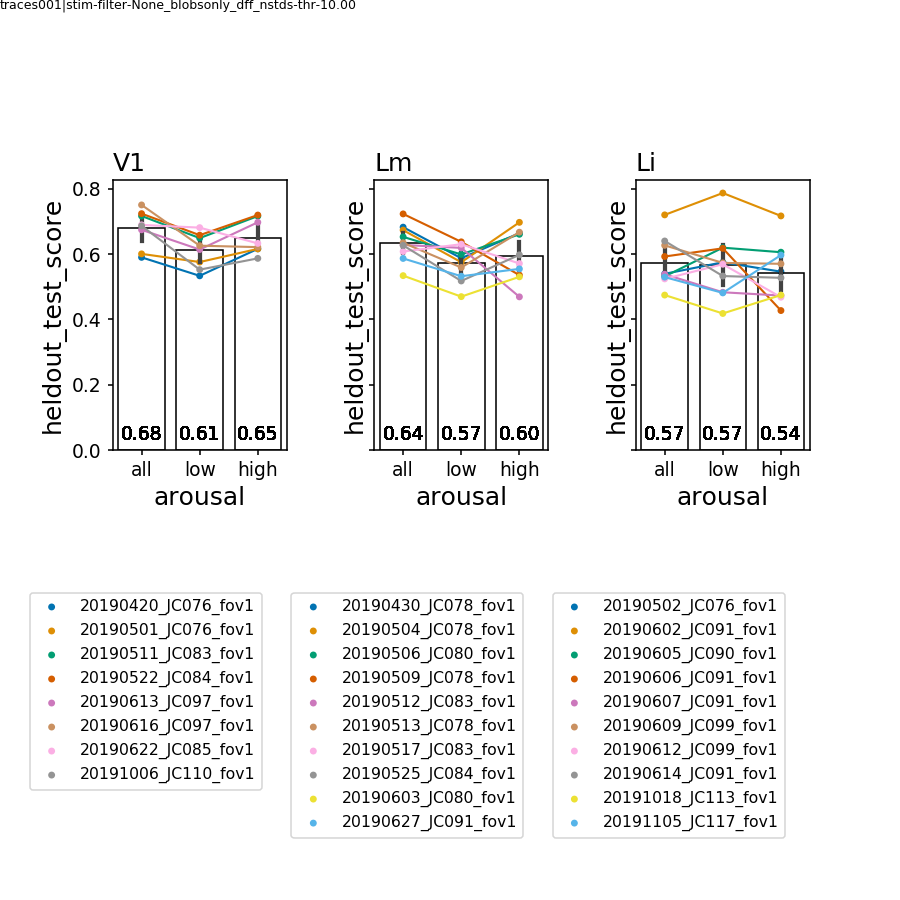

('/n/coxfs01/julianarhee/aggregate-visual-areas/behavior-state/decoding', 'heldout_test_score_pupil_area_by-area_min-50-cells')


In [261]:
#few = [] #['20191018_JC113_fov1', '20190605_JC090_fov1']
skip = ['20190507_JC083_fov1', '20190617_JC097_fov1', '20190510_JC083_fov1',
        '20190618_JC097_fov1', '20190508_JC083_fov1']
# skip=[]
skip.extend(too_few)

metric='heldout_test_score'
#metric='heldout_log2MI'

plotdf = df[~df['datakey'].isin(skip)]

ai=0
fig, axn = pl.subplots(1, 3, figsize=(8,8), dpi=dpi, sharex=True, sharey=True)
for ax, (visual_area, a_df) in zip(axn.flat[::-1], plotdf.groupby(['visual_area'])):
    sns.pointplot(x='arousal', y=metric, hue='datakey', data=a_df, ax=ax, palette='colorblind',
                     s=10, join=True, scale=0.5)
    sns.barplot(x='arousal', y=metric, data=a_df, ax=ax, 
                edgecolor=('k', 'k', 'k'), facecolor=(1,1,1,0))
    plotdf.apply(aggr.annotateBars, ax=ax, axis=1, fontsize=12, fontcolor='k')

    ax.set_title(visual_area, loc='left', fontsize=16)
    #ax.axhline(y=0.5, color='k', linestyle=':')
    
    ax.legend(bbox_to_anchor=(0.9, -0.5))
    ai+=1
    
pl.subplots_adjust(wspace=0.5, bottom=0.5, top=0.8)
#sns.despine(trim=True)

putils.label_figure(fig, data_id)
figname = '%s_%s_by-area_min-%i-cells' % (metric, face_feature, min_ncells)
pl.savefig(os.path.join(decoding_dir, '%s.svg' % figname))
print(decoding_dir, figname)

<IPython.core.display.Javascript object>


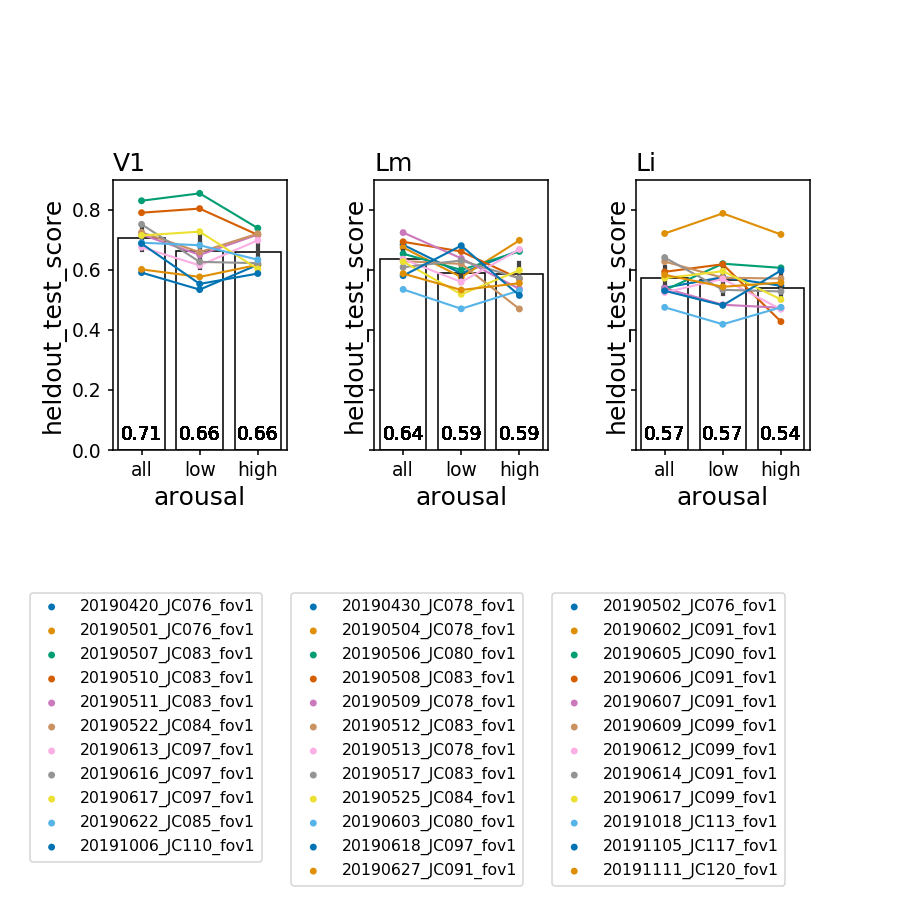

In [245]:
#few = [] #['20191018_JC113_fov1', '20190605_JC090_fov1']
# skip = ['20190507_JC083_fov1', '20190617_JC097_fov1',
#         '20190618_JC097_fov1', '20190508_JC083_fov1']
skip=[]
skip.extend(too_few)

metric='heldout_test_score'
#metric='heldout_log2MI'

plotdf = df[~df['datakey'].isin(skip)]

ai=0
fig, axn = pl.subplots(1, 3, figsize=(8,8), dpi=dpi, sharex=True, sharey=True)
for ax, (visual_area, a_df) in zip(axn.flat[::-1], plotdf.groupby(['visual_area'])):
    sns.pointplot(x='arousal', y=metric, hue='datakey', data=a_df, ax=ax, palette='colorblind',
                     s=10, join=True, scale=0.5)
    sns.barplot(x='arousal', y=metric, data=a_df, ax=ax, 
                edgecolor=('k', 'k', 'k'), facecolor=(1,1,1,0))
    plotdf.apply(aggr.annotateBars, ax=ax, axis=1, fontsize=12, fontcolor='k')

    ax.set_title(visual_area, loc='left', fontsize=16)
    #ax.axhline(y=0.5, color='k', linestyle=':')
    
    ax.legend(bbox_to_anchor=(0.9, -0.5))
    ai+=1
    
pl.subplots_adjust(wspace=0.5, bottom=0.5, top=0.8)
#sns.despine(trim=True)

In [286]:
cell_counts

,datakey,n_cells,visual_area
0,20190502_JC076_fov1,150,Li
1,20190602_JC091_fov1,241,Li
2,20190605_JC090_fov1,129,Li
3,20190606_JC091_fov1,136,Li
4,20190609_JC099_fov1,78,Li
5,20190617_JC099_fov1,25,Li
6,20191018_JC113_fov1,64,Li
7,20191105_JC117_fov1,79,Li
8,20191111_JC120_fov1,26,Li
9,20190430_JC078_fov1,187,Lm


# Load RF data

In [131]:
from pipeline.python.retinotopy import fit_2d_rfs as fitrf
from pipeline.python.rois.utils import load_roi_coords

In [132]:
reliable_only = True
#rfs_filter_by = None # Get all # match <EXP> datasets # 'drop_repeats'
rf_fit_thr = 0.05
fit_desc = fitrf.get_fit_desc(response_type=response_type)
reliable_str = 'reliable' if reliable_only else ''
rf_str = 'match%s_%s' % (experiment, reliable_str)
print(rf_str)


#### Get non-repeated FOV datasets
rf_dsets = sdata_exp[(sdata_exp['datakey'].isin(stim_datakeys))
                     & (sdata_exp['experiment'].isin(['rfs', 'rfs10']))].copy()
rf_dpaths, no_fits = rfutils.get_fit_dpaths(rf_dsets, traceid=traceid, fit_desc=fit_desc)
print("%i with no fits" % len(no_fits))

rfdf = rfutils.aggregate_rf_data(rf_dpaths, reliable_only=reliable_only, fit_desc=fit_desc,
                                            traceid=traceid, verbose=False)
rfdf = rfdf.reset_index(drop=True)

matchblobs_reliable
N dpaths: 31, N unfit: 0
N datasets included: 31, N sessions excluded: 4
0 with no fits


#### Get position info

In [133]:
aggr_rf_dir = os.path.join(aggregate_dir, 'receptive-fields', '%s__%s' % (traceid, fit_desc))
print(aggr_rf_dir)
rf_filter_by=None

#df_fpath = os.path.join(aggr_rf_dir, 'fits_and_coords_%s_%s_%s.pkl' % (rf_filter_by, reliable_str, rfname))
df_fpath =  os.path.join(aggr_rf_dir, 'fits_and_coords_%s_%s.pkl' % (rf_filter_by, reliable_str))
print(df_fpath)

get_positions = False
if os.path.exists(df_fpath) and get_positions is False:
    print("Loading existing RF coord conversions...")
    try:
        with open(df_fpath, 'rb') as f:
            df= pkl.load(f)
        rfdf = df['df']
    except Exception as e:
        get_positions = True
print(get_positions)

/n/coxfs01/julianarhee/aggregate-visual-areas/receptive-fields/traces001__fit-2dgaus_dff-no-cutoff
/n/coxfs01/julianarhee/aggregate-visual-areas/receptive-fields/traces001__fit-2dgaus_dff-no-cutoff/fits_and_coords_None_reliable.pkl
Loading existing RF coord conversions...
False


In [134]:
if get_positions:
    print("Calculating RF coord conversions...")
    pos_params = ['fov_xpos', 'fov_xpos_pix', 'fov_ypos', 'fov_ypos_pix', 'ml_pos','ap_pos']
    for p in pos_params:
        rfdf[p] = ''
    p_list=[]
    for (animalid, session, fovnum), g in rfdf.groupby(['animalid', 'session', 'fovnum']):
        fcoords = load_roi_coords(animalid, session, 'FOV%i_zoom2p0x' % fovnum, 
                                  traceid=traceid, create_new=False)

        for ei, e_df in g.groupby(['experiment']):
            cell_ids = e_df['cell'].unique()
            p_ = fcoords['roi_positions'].loc[cell_ids]
            for p in pos_params:
                rfdf[p][e_df.index] = p_[p].values
    # with open(df_fpath, 'wb') as f:
    #     pkl.dump(expdf, f, protocol=pkl.HIGHEST_PROTOCOL)

In [262]:
rfdf.head()

,r2,fwhm_x,fwhm_y,theta,x0,y0,animalid,cell,datakey,experiment,...,fwhm_avg,std_avg,area,datakey_ix,fov_xpos,fov_xpos_pix,fov_ypos,fov_ypos_pix,ml_pos,ap_pos
0,0.826039,23.640365,13.125770,0.117896,6.700889,-8.282818,JC076,0,20190502_JC076_fov1,rfs,...,18.383068,7.822582,176.519678,0,85.2665,37,218.928,115,753.872,1092.33
1,0.725070,43.796452,29.207447,0.234407,-22.165338,-2.970096,JC076,84,20190502_JC076_fov1,rfs,...,36.501949,15.532744,727.690433,0,638.347,277,605.382,318,367.418,539.253
2,0.701576,47.503138,24.790225,0.458457,15.301437,31.251545,JC076,115,20190502_JC076_fov1,rfs,...,36.146682,15.381567,669.910720,0,1034.72,449,788.139,414,184.661,142.879
3,0.781400,23.130716,44.809417,0.155088,2.496442,37.699467,JC076,120,20190502_JC076_fov1,rfs,...,33.970067,14.455348,589.620427,0,956.368,415,761.487,400,211.313,221.232
4,0.627347,32.132070,25.065036,5.892774,0.014677,17.244112,JC076,135,20190502_JC076_fov1,rfs,...,28.598553,12.169597,458.164233,0,1115.38,484,740.546,389,232.254,62.2215


## Calculate overlap with stimulus (all RFs)

In [142]:
rf_fit_params = ['cell', 'std_x', 'std_y', 'theta', 'x0', 'y0']

o_list=[]
for (visual_area, animalid, session, fovnum, datakey, rfname), g in rfdf.groupby(['visual_area', 'animalid', 'session', 'fovnum', 'datakey', 'experiment']):

    if datakey not in MEANS.keys(): # No blob data
        continue
        
    # Convert RF fit params to polygon
    g.index = g['cell'].values
    rf_polys = rfutils.rfs_to_polys(g[rf_fit_params])

    # Get stimulus info
    S = util.Session(animalid, session, 'FOV%i_zoom2p0x' % fovnum)
    stim_xpos, stim_ypos = S.get_stimulus_coordinates(experiments=[experiment])
    stim_sizes = S.get_stimulus_sizes(size_tested=[experiment])

    # Convert stimuli to polyon bounding boxes
    stim_polys = [(blob_sz, rfutils.stimsize_poly(blob_sz, xpos=stim_xpos, ypos=stim_ypos)) \
                  for blob_sz in stim_sizes[experiment]]
    
    # Get all pairwise overlaps (% of smaller ellipse that overlaps larger ellipse)
    overlaps = pd.concat([rfutils.get_proportion_overlap(rf_poly, stim_poly) \
                for stim_poly in stim_polys for rf_poly in rf_polys]).rename(columns={'row': 'cell', 'col': 'stim_size'})
    metadict={'visual_area': visual_area, 'animalid': animalid, 
              'session': session, 'fovnum': fovnum, 'datakey': datakey, 'rfname': rfname}
    o_ = putils.add_meta_to_df(overlaps, metadict)
    o_list.append(o_)

stim_overlaps = pd.concat(o_list, axis=0).reset_index(drop=True)

Creating blobs object [JC076|20190502|FOV1_zoom2p0x|traces001]
Stimuli presented at coords: (-5, 8)
Creating blobs object [JC076|20190502|FOV1_zoom2p0x|traces001]
Creating blobs object [JC090|20190605|FOV1_zoom2p0x|traces001]
Stimuli presented at coords: (15, 0)
Creating blobs object [JC090|20190605|FOV1_zoom2p0x|traces001]
Creating blobs object [JC091|20190602|FOV1_zoom2p0x|traces001]
Stimuli presented at coords: (20, -8)
Creating blobs object [JC091|20190602|FOV1_zoom2p0x|traces001]
Creating blobs object [JC091|20190602|FOV1_zoom2p0x|traces001]
Stimuli presented at coords: (20, -8)
Creating blobs object [JC091|20190602|FOV1_zoom2p0x|traces001]
Creating blobs object [JC091|20190606|FOV1_zoom2p0x|traces001]
Stimuli presented at coords: (20, -8)
Creating blobs object [JC091|20190606|FOV1_zoom2p0x|traces001]
Creating blobs object [JC091|20190607|FOV1_zoom2p0x|traces001]
Stimuli presented at coords: (20, -5)
Creating blobs object [JC091|20190607|FOV1_zoom2p0x|traces001]
Creating blobs obj

#### Select subset of RF data

In [136]:
r_list=[]
for datakey, expdf in dsets.groupby(['datakey']):
    # Get active blob cells
    exp_rids = sorted([r for r in MEANS[datakey].columns if putils.isnumber(r)])
    
    # Get current fov's RFs
    rdf = rfdf[rfdf['datakey']==datakey].copy()
    if len(rdf)==0:
        print("--- no RF! %s" % datakey)
        continue
    
    # If have both rfs/rfs10, pick the best one
    if len(rdf['experiment'].unique())>1:
        rf_rids = rdf[rdf['experiment']=='rfs']['cell'].unique()
        rf10_rids = rdf[rdf['experiment']=='rfs10']['cell'].unique()
        same_as_rfs = np.intersect1d(rf_rids, exp_rids)
        same_as_rfs10 = np.intersect1d(rf10_rids, exp_rids)
        rfname = 'rfs' if len(same_as_rfs) > len(same_as_rfs10) else 'rfs10'
        print("(%s) Selecting %s, overlappig rfs, %i | rfs10, %i (of %i cells)" 
              % (datakey, rfname, len(same_as_rfs), len(same_as_rfs10), len(exp_rids)))
        r_list.append(rdf[rdf['experiment']==rfname])
    else:
        r_list.append(rdf)
RFs = pd.concat(r_list, axis=0)


(20190602_JC091_fov1) Selecting rfs10, overlappig rfs, 33 | rfs10, 59 (of 241 cells)
(20190613_JC097_fov1) Selecting rfs10, overlappig rfs, 61 | rfs10, 88 (of 166 cells)
(20190616_JC097_fov1) Selecting rfs10, overlappig rfs, 98 | rfs10, 119 (of 296 cells)
(20190618_JC097_fov1) Selecting rfs10, overlappig rfs, 13 | rfs10, 24 (of 116 cells)
(20190622_JC085_fov1) Selecting rfs10, overlappig rfs, 26 | rfs10, 97 (of 203 cells)
(20191006_JC110_fov1) Selecting rfs10, overlappig rfs, 46 | rfs10, 72 (of 217 cells)


In [155]:
RFs[['visual_area', 'datakey']].drop_duplicates()['visual_area'].value_counts()

Li    9
Lm    8
V1    8
Name: visual_area, dtype: int64

## Get cells in common to both BLOBS-responsive and RF-fits

In [263]:
d_list = []
c_list = []
for (visual_area, datakey), rdf in stim_overlaps.groupby(['visual_area', 'datakey']):
    if datakey not in MEANS.keys():
        print("No <%s> for RF key: %s" % (experiment, datakey))
        continue
    
    # Get EXPERIMENT responsive cells
    exp_rids = [r for r in MEANS[datakey].columns if putils.isnumber(r)]
    
    # If have both rfs/rfs10, pick the best one
    if len(rdf['rfname'].unique())>1:
        rf_rids = rdf[rdf['rfname']=='rfs']['cell'].unique()
        rf10_rids = rdf[rdf['rfname']=='rfs10']['cell'].unique()
        same_as_rfs = np.intersect1d(rf_rids, exp_rids)
        same_as_rfs10 = np.intersect1d(rf10_rids, exp_rids)
        rfname = 'rfs' if len(same_as_rfs) > len(same_as_rfs10) else 'rfs10'
        print("(%s) Selecting %s, overlappig rfs, %i | rfs10, %i (of %i cells)" 
              % (datakey, rfname, len(same_as_rfs), len(same_as_rfs10), len(exp_rids)))
        curr_rfdf = rdf[rdf['rfname']==rfname].copy()
    else:
        curr_rfdf = rdf.copy()
    
    rf_rids = curr_rfdf['cell'].unique()
    # Get cells in common
    common_rids = np.intersect1d(exp_rids, rf_rids)
    print("[%s] %s, %i cells" % (visual_area, datakey, len(common_rids)))
    c_list.append(pd.DataFrame({'visual_area': visual_area, 'datakey': datakey, 
                                'rfname': rfname, 'n_cells': len(common_rids)}, index=[i]))
    
    d_list.append(rdf[rdf['cell'].isin(common_rids)].copy())
    
has_blobs = pd.concat(d_list, axis=0)
print(has_blobs.shape)

common_counts = pd.concat(c_list, axis=0)


[Li] 20190502_JC076_fov1, 15 cells
(20190602_JC091_fov1) Selecting rfs10, overlappig rfs, 33 | rfs10, 59 (of 241 cells)
[Li] 20190602_JC091_fov1, 59 cells
[Li] 20190605_JC090_fov1, 9 cells
[Li] 20190606_JC091_fov1, 26 cells
[Li] 20190607_JC091_fov1, 41 cells
[Li] 20190609_JC099_fov1, 22 cells
[Li] 20190612_JC099_fov1, 21 cells
[Li] 20190614_JC091_fov1, 52 cells
[Li] 20190617_JC099_fov1, 4 cells
[Li] 20191008_JC091_fov1, 20 cells
[Li] 20191018_JC113_fov1, 6 cells
[Li] 20191105_JC117_fov1, 0 cells
[Li] 20191111_JC120_fov1, 1 cells
[Lm] 20190430_JC078_fov1, 31 cells
[Lm] 20190504_JC078_fov1, 10 cells
[Lm] 20190506_JC080_fov1, 30 cells
[Lm] 20190508_JC083_fov1, 61 cells
[Lm] 20190509_JC078_fov1, 11 cells
[Lm] 20190512_JC083_fov1, 39 cells
[Lm] 20190513_JC078_fov1, 17 cells
[Lm] 20190517_JC083_fov1, 20 cells
[Lm] 20190525_JC084_fov1, 36 cells
[Lm] 20190603_JC080_fov1, 53 cells
(20190618_JC097_fov1) Selecting rfs10, overlappig rfs, 13 | rfs10, 24 (of 116 cells)
[Lm] 20190618_JC097_fov1, 24 c

In [264]:
has_blobs[['visual_area', 'datakey']].drop_duplicates()['visual_area'].value_counts()

Li    12
Lm    12
V1    11
Name: visual_area, dtype: int64

In [152]:
stim_overlaps.head()

,area_overlap,stim_size,perc_overlap,cell,animalid,session,rfname,datakey,visual_area,fovnum
0,0.778584,10,0.007786,0.0,JC076,20190502,rfs,20190502_JC076_fov1,Li,1
1,100.000000,10,1.000000,84.0,JC076,20190502,rfs,20190502_JC076_fov1,Li,1
2,100.000000,10,1.000000,115.0,JC076,20190502,rfs,20190502_JC076_fov1,Li,1
3,96.249421,10,0.962494,120.0,JC076,20190502,rfs,20190502_JC076_fov1,Li,1
4,100.000000,10,1.000000,135.0,JC076,20190502,rfs,20190502_JC076_fov1,Li,1


In [266]:
overlap_thr = 0.8
has_blobs[has_blobs['perc_overlap']>=overlap_thr][['visual_area', 'datakey', 'cell']].drop_duplicates().groupby(['visual_area']).count()

,datakey,cell
visual_area,,
Li,241,241
Lm,273,273
V1,734,734


In [265]:
curr_min_pass = has_blobs[has_blobs['perc_overlap']>=overlap_thr][['visual_area', 'datakey', 'cell']].drop_duplicates().groupby(['visual_area']).count()['cell'].min()
print("Min N pass: %i (overlap thr=%.2f)" % (curr_min_pass, overlap_thr))

Min N pass: 241 (overlap thr=0.80)


In [216]:
# SDF={}
# for datakey, g in globaldf.groupby(['datakey']):
#     session, animalid, fov_ = datakey.split('_')
#     fovnum = int(fov_[3:])
#     obj = util.Objects(animalid, session, 'FOV%i_zoom2p0x' %  fovnum, traceid=traceid)
#     sdf = obj.get_stimuli()
#     SDF[datakey] = sdf

In [269]:
overlap_thr=0.8
n_iterations=100
NCELLS =  60
min_ncells=20

#for overlap_thr, NCELLS in ncells_dict.items():
print("-------- Overlap: %.2f --------" % overlap_thr)
# Get list of eligible cells from all FOVs
# globaldf = filter_rois(has_blobs[has_blobs['datakey'].isin(stim_datakeys)], overlap_thr=overlap_thr) 



-------- Overlap: 0.80 --------


In [270]:
# for k, d in SDF.items():
#     if len(np.where(sdf['morphlevel']!=d['morphlevel'])[0]) > 0:
#         print(k)
#     if len(np.where(sdf['size']!=d['size'])[0]) > 0:
#         print(k)

In [271]:
overlap_thr=0.8
pass_dsets = has_blobs[(has_blobs['perc_overlap']>=overlap_thr)].copy()

cell_counts = pass_dsets[['visual_area', 'datakey', 'cell']].drop_duplicates().groupby(['visual_area', 'datakey']).count().reset_index()
cell_counts = cell_counts.rename(columns={'cell': 'n_cells'})
cell_counts

,visual_area,datakey,n_cells
0,Li,20190502_JC076_fov1,14
1,Li,20190602_JC091_fov1,57
2,Li,20190605_JC090_fov1,8
3,Li,20190606_JC091_fov1,21
4,Li,20190607_JC091_fov1,39
5,Li,20190609_JC099_fov1,20
6,Li,20190612_JC099_fov1,18
7,Li,20190614_JC091_fov1,45
8,Li,20190617_JC099_fov1,1
9,Li,20191008_JC091_fov1,12


In [272]:
min_ncells =20
too_few_cells = cell_counts[cell_counts['n_cells'] < min_ncells]['datakey'].unique()
print("%i datasets, too few (min=%i cells)" % (len(too_few_cells), min_ncells))
#print too_few_cells

cell_counts[~cell_counts['datakey'].isin(too_few_cells)]

13 datasets, too few (min=20 cells)


,visual_area,datakey,n_cells
1,Li,20190602_JC091_fov1,57
3,Li,20190606_JC091_fov1,21
4,Li,20190607_JC091_fov1,39
5,Li,20190609_JC099_fov1,20
7,Li,20190614_JC091_fov1,45
12,Lm,20190430_JC078_fov1,24
14,Lm,20190506_JC080_fov1,27
15,Lm,20190508_JC083_fov1,52
17,Lm,20190512_JC083_fov1,33
20,Lm,20190525_JC084_fov1,30


In [273]:
pass_dsets.head()

,area_overlap,stim_size,perc_overlap,cell,animalid,session,rfname,datakey,visual_area,fovnum
1,100.000000,10,1.000000,84.0,JC076,20190502,rfs,20190502_JC076_fov1,Li,1
2,100.000000,10,1.000000,115.0,JC076,20190502,rfs,20190502_JC076_fov1,Li,1
3,96.249421,10,0.962494,120.0,JC076,20190502,rfs,20190502_JC076_fov1,Li,1
4,100.000000,10,1.000000,135.0,JC076,20190502,rfs,20190502_JC076_fov1,Li,1
6,100.000000,10,1.000000,169.0,JC076,20190502,rfs,20190502_JC076_fov1,Li,1


In [274]:
curr_dkeys = pass_dsets['datakey'].unique()
curr_missing_dlc = [k for k in curr_dkeys if '%s_%s' % (k, experiment) not in PUPIL.keys()]
curr_missing_dlc


['20191008_JC091_fov1']

In [177]:
reload(dlcutils)

<module 'pipeline.python.classifications.dlc_utils' from '/net/coxfs01/srv/export/coxfs01/share_root/2p-pipeline/repos/2p-pipeline/pipeline/python/classifications/dlc_utils.py'>

In [178]:
no_dlc = []
for dkey in curr_missing_dlc:
    if '%s_%s' % (dkey, experiment) in PUPIL.keys():
        continue
    print("[%s] getting extracted feature: %s" % (dkey, face_feature))
    session, animalid, fov = dkey.split('_')
    fovnum = int(fov[3:])
    fov = 'FOV%i_zoom2p0x' % fovnum

    #### Get labels
    labels_dfile = glob.glob(os.path.join(rootdir, animalid, session, fov, 'combined_*%s*' % experiment, 'traces',
                          '%s*' % traceid, 'data_arrays', 'labels.npz'))[0]
    l = np.load(labels_dfile)
    labels = pd.DataFrame(data=l['labels_data'], columns=l['labels_columns'])

    #### Load pupil data
    facemeta, pupildata = dlcutils.load_pose_data(animalid, session, fovnum, experiment, dlc_results_dir, 
                                                  feature_list=[face_feature], epoch='trial_alignment', 
                                                  pre_ITI_ms=iti_pre_ms, post_ITI_ms=iti_post_ms)
    
    if pupildata is None:
        print("----- skipping %s (no dlc)" % dkey)
        no_dlc.append(dkey)
        continue
        
    #### Parse pupil data into traces
    pupiltraces = dlcutils.get_pose_traces(facemeta, pupildata, labels, feature='pupil_area')

    #### Add to dict
    datakey ='%s_%s_fov%i_%s' % (session, animalid, fovnum, experiment)  
    PUPIL[datakey] = pupiltraces


# This is a dict, keys are datakeys
with open(pupil_fpath, 'wb') as f:
    pkl.dump(PUPIL, f, protocol=pkl.HIGHEST_PROTOCOL)


[20191008_JC091_fov1] getting extracted feature: pupil_area
Loading pose data (dlc)
('[blobs] Found runs:', ['1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12', '13'])
... finding movies for dset: 20191008_JC091_fov1_blobs
(0, '/n/coxfs01/2p-data/eyetracker_tmp/20191008_JC091_fov1_blobs_f1_20191008114954692819')
(1, '/n/coxfs01/2p-data/eyetracker_tmp/20191008_JC091_fov1_blobs_f2_20191008130145399159')
(2, '/n/coxfs01/2p-data/eyetracker_tmp/20191008_JC091_fov1_blobs_f3_20191008135135055724')
(3, '/n/coxfs01/2p-data/eyetracker_tmp/20191008_JC091_fov1_blobs_f4_20191008143825761217')
(4, '/n/coxfs01/2p-data/eyetracker_tmp/20191008_JC091_fov1_blobs_f5_20191008155442610578')
(5, '/n/coxfs01/2p-data/eyetracker_tmp/20191008_JC091_fov1_blobs_f6_20191008163153063257')
(6, '/n/coxfs01/2p-data/eyetracker_tmp/20191008_JC091_fov1_blobs_f7_20191008170323771409')
(7, '/n/coxfs01/2p-data/eyetracker_tmp/20191008_JC091_fov1_blobs_f8_20191008174953035553')
(8, '/n/coxfs01/2p-data/eyetracker_tmp

...curr run: 3 [20190511_JC083_fov1_blobs_f3DLC_resnet50_facetrackingJan25shuffle1_391800.h5]
...curr run: 4 [20190511_JC083_fov1_blobs_f4DLC_resnet50_facetrackingJan25shuffle1_391800.h5]
...curr run: 5 [20190511_JC083_fov1_blobs_f5DLC_resnet50_facetrackingJan25shuffle1_391800.h5]
...curr run: 6 [20190511_JC083_fov1_blobs_f6DLC_resnet50_facetrackingJan25shuffle1_391800.h5]
... done parsing!
Parsing pose data with MW
Missing 1 trials total


In [275]:
report_metric = 'heldout_test_score'
m0=0
m100=106
C_value=1
n_iterations = 100
skip = []
use_quartiles = True

n_datakeys = len(pass_dsets['datakey'].unique())
metric = 'heldout_test_score'

d_list=[]; d_list_chance=[]; dkeys=[]; vkeys=[];with open(params_fpath, 'w') as f:
    json.dump(params, f, indent=4)
n_datakeys = len(pass_dsets['datakey'].unique())
for di, ((visual_area, datakey), curr_stimoverlaps) in enumerate(pass_dsets.groupby(['visual_area', 'datakey'])):
    if datakey in too_few_cells:
        print("(%s) Too few pass: %i"% (datakey, len(curr_stimoverlaps['cell'].unique())))
        continue

    if di % 5 == 0:
        print("%i of %i datakeys" % (int(di+1), n_datakeys))
        
    if '%s_%s' % (datakey, experiment) not in PUPIL.keys():
        print("Missing PUPIL: %s" % datakey)
        continue
        
    # ------ Neural ----------------------------------------------
    # Only select cells that pass conditions
    print("**** [%s] %s *****" % (visual_area, datakey))
    config_list = MEANS[datakey]['config']
    roi_list = curr_stimoverlaps['cell'].unique()
    ncells_t = MEANS[datakey].shape[1]-1
    neuraldf = MEANS[datakey][roi_list].copy() 
    neuraldf['config'] = config_list
    # sdf = SDF[datakey].copy()
    print("... (%s | %s) %i of %i cells" % (visual_area, datakey, len(roi_list), ncells_t))    
    
    # ------ STIMULUS INFO -----------------------------------------
    session, animalid, fov_ = datakey.split('_')
    fovnum = int(fov_[3:])
    obj = util.Objects(animalid, session, 'FOV%i_zoom2p0x' %  fovnum, traceid=traceid)
    sdf = obj.get_stimuli()
    
    # ------ PUPIL --------------------------------------------------
    pupiltraces = PUPIL['%s_%s' % (datakey, experiment)].copy()

    #### Resample pupil
    desired_nframes = 60 #len(out_ixs) # 60
    binned_pupil = bin_pupil_traces(pupiltraces, feature_name=face_feature,
                                         in_rate=20.0, out_rate=new_framerate, 
                                         min_nframes=desired_nframes, stim_on=stim_on)
    trials_ = sorted(pupiltraces['trial'].unique())
    frames_ = np.arange(0, desired_nframes)
    pupil_trialmat = pd.DataFrame(np.vstack([p[face_feature].values for trial, p in binned_pupil.groupby(['trial'])]),
                                  index=trials_, columns=frames_)
    pupil_r = pupil_trialmat.T.unstack().reset_index().rename(columns={'level_0': 'trial', 
                                                                   'level_1': 'frame',
                                                                   0: 'pupil'})
    pupildf = pd.concat([g.mean(axis=0) for t, g in pupil_r.groupby(['trial'])], axis=1).T
    
    # ------ Split trials by quantiles ---------------------------------
    if use_quartiles:
        pupil_quantiles = pupildf.pupil.quantile([0.25,0.5,0.75])
        low_pupil_thr = pupil_quantiles[0.25]
        high_pupil_thr = pupil_quantiles[0.75]
        pupil_low = pupildf[pupildf['pupil']<=low_pupil_thr].copy()
        pupil_high = pupildf[pupildf['pupil']>=high_pupil_thr].copy()
    else:
        pupildf['quantile'] = pd.qcut(pupildf['pupil'], 3, labels=False)
        pupil_low = pupildf[pupildf['quantile']==0].copy()
        pupil_high = pupildf[pupildf['quantile']==2].copy()

    # Get trial indices of low/high pupil 
    low_trial_ixs = pupil_low['trial'].unique()
    high_trial_ixs = pupil_high['trial'].unique()
    all_trial_ixs = pupildf['trial'].unique()
    
    # Fit ALL
    tmp_d_list=[]
    tmp_shuf_list = []
    for arousal, curr_trial_ixs in zip(['all', 'low', 'high'], [all_trial_ixs, low_trial_ixs, high_trial_ixs]):
        curr_data = neuraldf.loc[curr_trial_ixs].copy()
        iterdict, iterdict_chance = fit_classifier_bootstrap(curr_data, sdf, m0=m0, m100=m100, n_iterations=n_iterations,
                                      cv_nfolds=cv_nfolds, test_size=test_size, C_value=C_value)

        iterdict['arousal'] = arousal
        iterdict_chance['arousal'] = arousal
        tmp_d_list.append(pd.DataFrame(iterdict, index=[i])) #df)
        tmp_shuf_list.append(pd.DataFrame(iterdict_chance, index=[i])) #df_chance)
        print("%s: %.2f (chance=%.2f)" % (arousal, iterdict[report_metric], iterdict_chance[report_metric]))

        i+=1
        
    tmp_df = pd.concat(tmp_d_list, axis=0)
    metadict = {'visual_area': visual_area, 'datakey': datakey}
    tmp_df = putils.add_meta_to_df(tmp_df, metadict)
    print(tmp_df.shape)
    tmp_chance = pd.concat(tmp_shuf_list, axis=0)
    tmp_chance = putils.add_meta_to_df(tmp_chance, metadict)
    
    d_list.append(tmp_df)
    d_list_chance.append(tmp_chance)

df = pd.concat(d_list, axis=0)
df_chance = pd.concat(d_list_chance, axis=0)

(20190502_JC076_fov1) Too few pass: 14
**** [Li] 20190602_JC091_fov1 *****
... (Li | 20190602_JC091_fov1) 57 of 241 cells
Creating blobs object [JC091|20190602|FOV1_zoom2p0x|traces001]
all: 0.74 (chance=0.49)
low: 0.76 (chance=0.49)
high: 0.70 (chance=0.50)
(3, 41)
(20190605_JC090_fov1) Too few pass: 8
**** [Li] 20190606_JC091_fov1 *****
... (Li | 20190606_JC091_fov1) 21 of 136 cells
Creating blobs object [JC091|20190606|FOV1_zoom2p0x|traces001]
all: 0.57 (chance=0.49)
low: 0.58 (chance=0.49)
high: 0.43 (chance=0.48)
(3, 41)
**** [Li] 20190607_JC091_fov1 *****
... (Li | 20190607_JC091_fov1) 39 of 260 cells
Creating blobs object [JC091|20190607|FOV1_zoom2p0x|traces001]
all: 0.62 (chance=0.49)
low: 0.50 (chance=0.49)
high: 0.45 (chance=0.53)
(3, 41)
6 of 35 datakeys
**** [Li] 20190609_JC099_fov1 *****
... (Li | 20190609_JC099_fov1) 20 of 78 cells
Creating blobs object [JC099|20190609|FOV1_zoom2p0x|traces001]
all: 0.62 (chance=0.51)
low: 0.57 (chance=0.54)
high: 0.49 (chance=0.49)
(3, 41)

### Save overlap results

In [276]:
results_fpath = os.path.join(decoding_dir, 'results_overlap-thr-%.2f.pkl' % overlap_thr)
# params_fpath = os.path.join(decoding_dir, 'params_overlap.json')

# params = {'m0': m0, 'm100': m100, 'C_value': C_value, 'n_iterations': n_iterations,
#          'overlap_thr': overlap_thr}
results = {'df': df, 'df_chance': df_chance, 'cell_counts': cell_counts, 
           'has_blobs': has_blobs, 'pass_dsets': pass_dsets}

with open(results_fpath, 'wb') as f:
    pkl.dump(results, f, protocol=pkl.HIGHEST_PROTOCOL)
    
# with open(params_fpath, 'w') as f:
#     json.dump(params, f, indent=4)
    


<IPython.core.display.Javascript object>


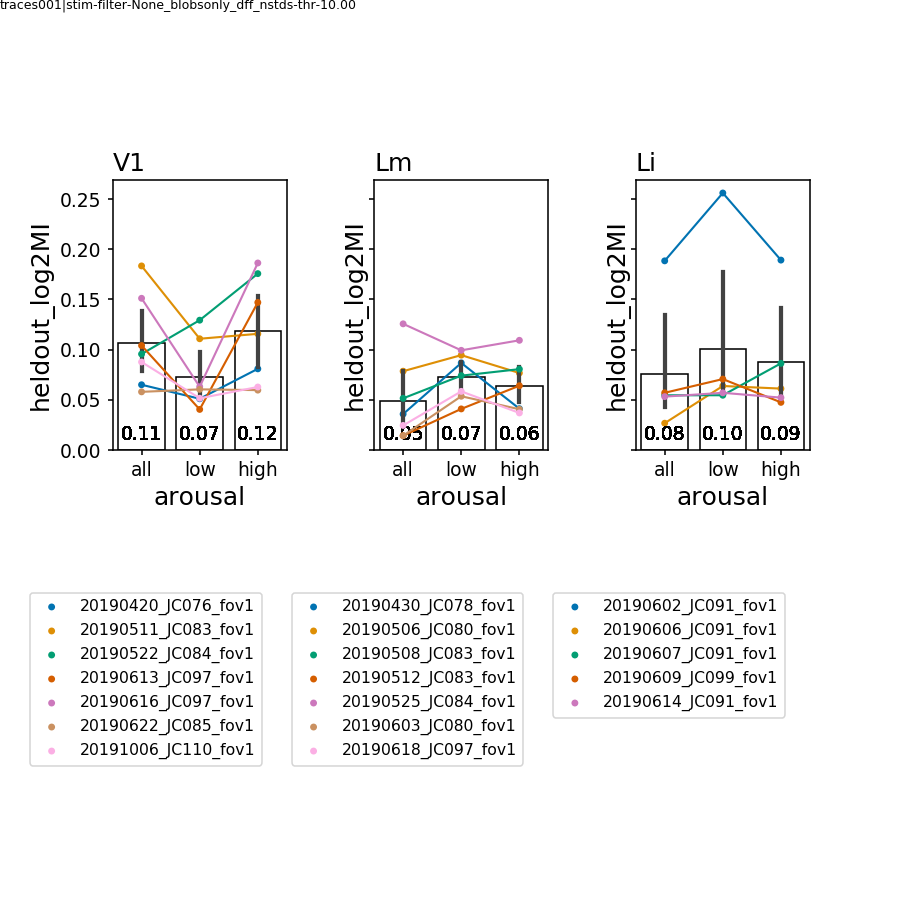

('/n/coxfs01/julianarhee/aggregate-visual-areas/behavior-state/decoding', 'heldout_log2MI_overlap-thr-0.80_pupil_area_by-area_min-20-cells')


In [278]:
#few = [] #['20191018_JC113_fov1', '20190605_JC090_fov1']
skip = ['20190507_JC083_fov1', '20190617_JC097_fov1', '20190510_JC083_fov1'] #,
       #'20190618_JC097_fov1', '20190508_JC083_fov1']
# skip=[]
skip.extend(too_few)

#metric='heldout_test_score'
metric='heldout_log2MI'

plotdf = df[~df['datakey'].isin(skip)]

ai=0
fig, axn = pl.subplots(1, 3, figsize=(8,8), dpi=dpi, sharex=True, sharey=True)
for ax, (visual_area, a_df) in zip(axn.flat[::-1], plotdf.groupby(['visual_area'])):
    sns.pointplot(x='arousal', y=metric, hue='datakey', data=a_df, ax=ax, palette='colorblind',
                     s=10, join=True, scale=0.5)
    sns.barplot(x='arousal', y=metric, data=a_df, ax=ax, 
                edgecolor=('k', 'k', 'k'), facecolor=(1,1,1,0))
    plotdf.apply(aggr.annotateBars, ax=ax, axis=1, fontsize=12, fontcolor='k')

    ax.set_title(visual_area, loc='left', fontsize=16)
    #ax.axhline(y=0.5, color='k', linestyle=':')
    
    ax.legend(bbox_to_anchor=(0.9, -0.5))
    ai+=1
    
pl.subplots_adjust(wspace=0.5, bottom=0.5, top=0.8)
#sns.despine(trim=True)

pl.subplots_adjust(wspace=0.5, bottom=0.5, top=0.8)
#sns.despine(trim=True)

putils.label_figure(fig, data_id)
figname = '%s_overlap-thr-%.2f_%s_by-area_min-%i-cells' % (metric, overlap_thr, face_feature, min_ncells)
pl.savefig(os.path.join(decoding_dir, '%s.svg' % figname))
print(decoding_dir, figname)

<IPython.core.display.Javascript object>


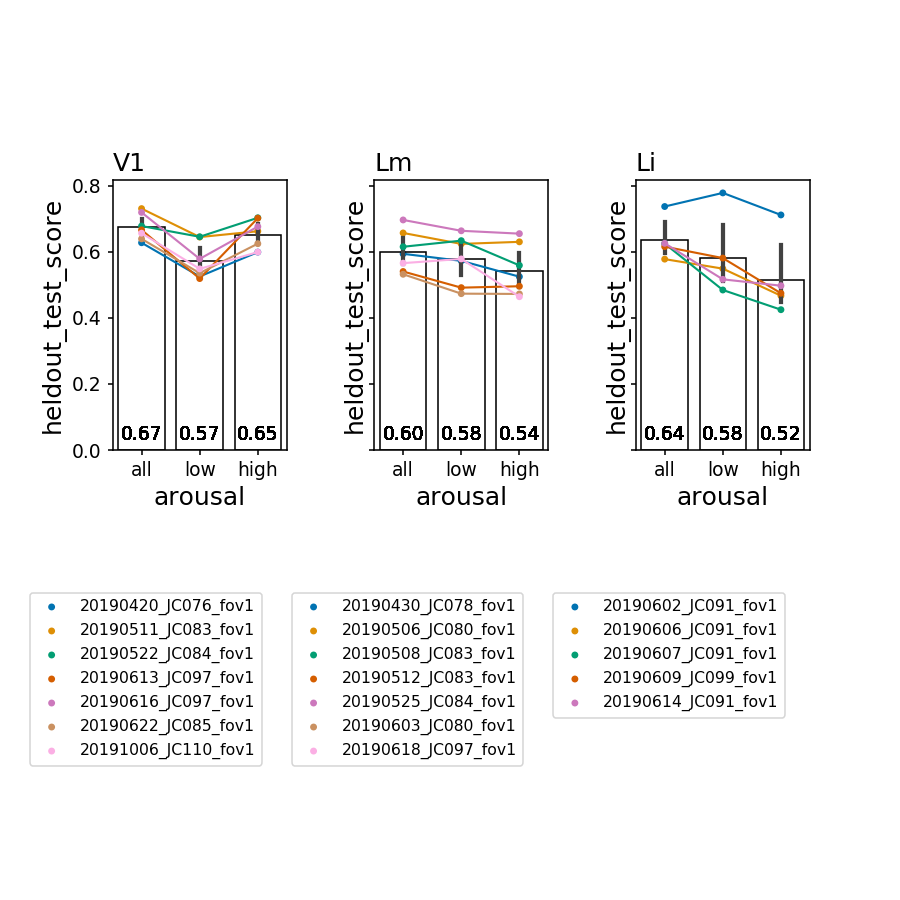

In [192]:
#few = [] #['20191018_JC113_fov1', '20190605_JC090_fov1']
skip = ['20190507_JC083_fov1', '20190617_JC097_fov1', '20190510_JC083_fov1'] #,
       #'20190618_JC097_fov1', '20190508_JC083_fov1']
# skip=[]
skip.extend(too_few)

metric='heldout_test_score'
#metric='heldout_log2MI'

plotdf = df[~df['datakey'].isin(skip)]

ai=0
fig, axn = pl.subplots(1, 3, figsize=(8,8), dpi=dpi, sharex=True, sharey=True)
for ax, (visual_area, a_df) in zip(axn.flat[::-1], plotdf.groupby(['visual_area'])):
    sns.pointplot(x='arousal', y=metric, hue='datakey', data=a_df, ax=ax, palette='colorblind',
                     s=10, join=True, scale=0.5)
    sns.barplot(x='arousal', y=metric, data=a_df, ax=ax, 
                edgecolor=('k', 'k', 'k'), facecolor=(1,1,1,0))
    plotdf.apply(aggr.annotateBars, ax=ax, axis=1, fontsize=12, fontcolor='k')

    ax.set_title(visual_area, loc='left', fontsize=16)
    #ax.axhline(y=0.5, color='k', linestyle=':')
    
    ax.legend(bbox_to_anchor=(0.9, -0.5))
    ai+=1
    
pl.subplots_adjust(wspace=0.5, bottom=0.5, top=0.8)
#sns.despine(trim=True)

cell_counts


In [237]:
metric = 'heldout_test_score'

d_list=[]; d_list_chance=[]; dkeys=[]; vkeys=[];
lo_list=[]; lo_list_chance=[]; 
hi_list=[]; hi_list_chance=[]; 

n_datakeys = len(pass_dsets['datakey'].unique())
for di, ((visual_area, datakey), ds) in enumerate(pass_dsets.groupby(['visual_area', 'datakey'])):
    if datakey in too_few_cells:
        print("(%s) Too few pass: %i"% (datakey, len(ds['cell'].unique())))
        continue

    if di % 5 == 0:
        print("%i of %i datakeys" % (int(di+1), n_datakeys))
    
    # ------ Neural ----------------------------------------------
    # Only select cells that pass conditions
    print("**** [%s] %s *****" % (visual_area, datakey))
    config_list = MEANS[datakey]['config']
    roi_list = ds['cell'].unique()
    ncells_t = MEANS[datakey].shape[1]-1
    neuraldf = MEANS[datakey][roi_list].copy() 
    neuraldf['config'] = config_list
    # sdf = SDF[datakey].copy()
    print("... (%s | %s) %i of %i cells" % (visual_area, datakey, len(roi_list), ncells_t))    
    
    # ------ PUPIL --------------------------------------------------
    pupiltraces = PUPIL['%s_%s' % (datakey, experiment)].copy()

    #### Resample pupil
    desired_nframes = 60 #len(out_ixs) # 60
    binned_pupil = bin_pupil_traces(pupiltraces, in_rate=20.0, out_rate=new_framerate, 
                                         min_nframes=desired_nframes)
    trials_ = sorted(pupiltraces['trial'].unique())
    frames_ = np.arange(0, desired_nframes)
    pupil_trialmat = pd.DataFrame(np.vstack([p['pupil'].values for trial, p in binned_pupil.groupby(['trial'])]),
                                  index=trials_, columns=frames_)
    pupil_r = pupil_trialmat.T.unstack().reset_index().rename(columns={'level_0': 'trial', 
                                                                   'level_1': 'frame',
                                                                   0: 'pupil'})
    pupildf = pd.concat([g.mean(axis=0) for t, g in pupil_r.groupby(['trial'])], axis=1).T
    
    # ------ Split trials by quantiles ---------------------------------
    pupil_quantiles = pupildf.pupil.quantile([0.25,0.5,0.75])
    low_pupil_thr = pupil_quantiles[0.25]
    high_pupil_thr = pupil_quantiles[0.75]
    pupil_low = pupildf[pupildf['pupil']<=low_pupil_thr].copy()
    pupil_high = pupildf[pupildf['pupil']>=high_pupil_thr].copy()

    # Get trial indices of low/high pupil 
    low_trial_ixs = sorted(pupil_low['trial'].unique())
    high_trial_ixs = sorted(pupil_high['trial'].unique())
    
    # Fit all
    curr_data = neuraldf.copy()
    df, df_chance = fit_svm(curr_data, sdf, m0=m0, m100=m100, C_value=C_value, n_iterations=n_iterations)
    print("all: %.2f (chance=%.2f)" % (df.mean()[metric], df_chance.mean()[metric]))
    d_list.append(df.mean(axis=0).T)
    d_list_chance.append(df_chance.mean(axis=0).T)
    
    # Fit LOW
    curr_data = neuraldf.loc[low_trial_ixs].copy()
    df, df_chance = fit_svm(curr_data, sdf, m0=m0, m100=m100, C_value=C_value, n_iterations=n_iterations)
    print("low: %.2f (chance=%.2f)" % (df.mean()[metric], df_chance.mean()[metric]))
    lo_list.append(df.mean(axis=0).T)
    lo_list_chance.append(df_chance.mean(axis=0).T)
    
    # Fit LOW
    curr_data = neuraldf.loc[high_trial_ixs].copy()
    df, df_chance = fit_svm(curr_data, sdf, m0=m0, m100=m100, C_value=C_value, n_iterations=n_iterations)
    print("high: %.2f (chance=%.2f)" % (df.mean()[metric], df_chance.mean()[metric]))
    hi_list.append(df.mean(axis=0).T)
    hi_list_chance.append(df_chance.mean(axis=0).T)
    
    dkeys.append(datakey)
    vkeys.append(visual_area)

(20190502_JC076_fov1) Too few pass: 14
**** [Li] 20190602_JC091_fov1 *****
... (Li | 20190602_JC091_fov1) 57 of 241 cells
all: 0.76 (chance=0.49)
low: 0.72 (chance=0.51)
high: 0.75 (chance=0.51)
(20190605_JC090_fov1) Too few pass: 8
**** [Li] 20190606_JC091_fov1 *****
... (Li | 20190606_JC091_fov1) 21 of 136 cells
all: 0.58 (chance=0.49)
low: 0.44 (chance=0.56)
high: 0.44 (chance=0.51)
**** [Li] 20190609_JC099_fov1 *****
... (Li | 20190609_JC099_fov1) 20 of 78 cells
all: 0.61 (chance=0.51)
low: 0.49 (chance=0.52)
high: 0.48 (chance=0.48)
(20190617_JC099_fov1) Too few pass: 1
(20191018_JC113_fov1) Too few pass: 5
(20191111_JC120_fov1) Too few pass: 1
**** [Lm] 20190430_JC078_fov1 *****
... (Lm | 20190430_JC078_fov1) 24 of 187 cells
all: 0.59 (chance=0.49)
low: 0.55 (chance=0.51)
high: 0.53 (chance=0.46)
(20190504_JC078_fov1) Too few pass: 8
11 of 24 datakeys
**** [Lm] 20190506_JC080_fov1 *****
... (Lm | 20190506_JC080_fov1) 27 of 226 cells
all: 0.67 (chance=0.51)
low: 0.70 (chance=0.51)

In [238]:
print(d_list[0].shape)
full_df = pd.concat(d_list, axis=1).T
full_chance = pd.concat(d_list_chance, axis=1).T
full_df['datakey'] = dkeys
full_chance['datakey'] = dkeys
full_df['visual_area'] = vkeys
full_chance['visual_area'] = vkeys

lo_df = pd.concat(lo_list, axis=1).T
lo_chance = pd.concat(lo_list_chance, axis=1).T
lo_df['datakey'] = dkeys
lo_chance['datakey'] = dkeys
lo_df['visual_area'] = vkeys
lo_chance['visual_area'] = vkeys

hi_df = pd.concat(hi_list, axis=1).T
hi_chance = pd.concat(hi_list_chance, axis=1).T
hi_df['datakey'] = dkeys
hi_chance['datakey'] = dkeys
hi_df['visual_area'] = vkeys
hi_chance['visual_area'] = vkeys


(12,)


<IPython.core.display.Javascript object>


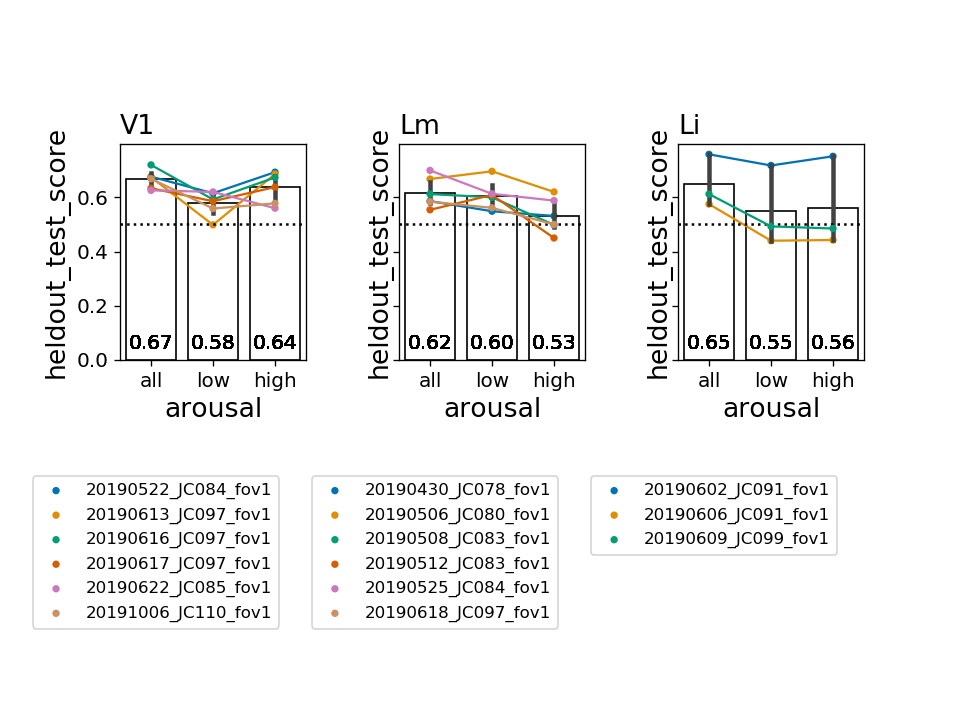

In [254]:
few = [] #['20191018_JC113_fov1', '20190605_JC090_fov1']
skip = ['20190507_JC083_fov1', '20190420_JC076_fov1']

metric='heldout_test_score'
#metric='heldout_aMI'

m_ = pd.concat([full_df[metric], lo_df[metric], hi_df[metric]], axis=1)
m_.columns = ['all', 'low', 'high']
# m_df['datakey'] = full_df['datakey']
m_df = m_.unstack().reset_index().rename(columns={'level_0': 'arousal', 'level_1': 'datakey', 0: metric})

m_df['datakey'] = [full_df.loc[i]['datakey'] for i in m_df['datakey']]
#m_df['visual_area'] = [full_df.loc[i]['visual_area'] for i in m_df['datakey']]
v_labels = pd.concat([full_df['visual_area'], lo_df['visual_area'], hi_df['visual_area']], axis=0).values
m_df['visual_area'] = v_labels

plotdf = m_df[~m_df['datakey'].isin(skip)]

# plot
ai=0
fig, axn = pl.subplots(1, 3, figsize=(8,6), dpi=dpi, sharex=True, sharey=True)
for ax, (visual_area, a_df) in zip(axn.flat[::-1], plotdf.groupby(['visual_area'])):
    sns.pointplot(x='arousal', y=metric, hue='datakey', data=a_df, ax=ax, palette='colorblind',
                 s=10, join=True, scale=0.5)
    sns.barplot(x='arousal', y=metric, data=a_df, ax=ax, 
                edgecolor=('k', 'k', 'k'), facecolor=(1,1,1,0))
    m_df.apply(aggr.annotateBars, ax=ax, axis=1, fontsize=12, fontcolor='k')

    ax.set_title(visual_area, loc='left', fontsize=16)
    ax.axhline(y=0.5, color='k', linestyle=':')
    
    ax.legend(bbox_to_anchor=(0.9, -0.5))
    ai+=1
    
pl.subplots_adjust(wspace=0.5, bottom=0.5, top=0.8)
#sns.despine(trim=True)

<IPython.core.display.Javascript object>


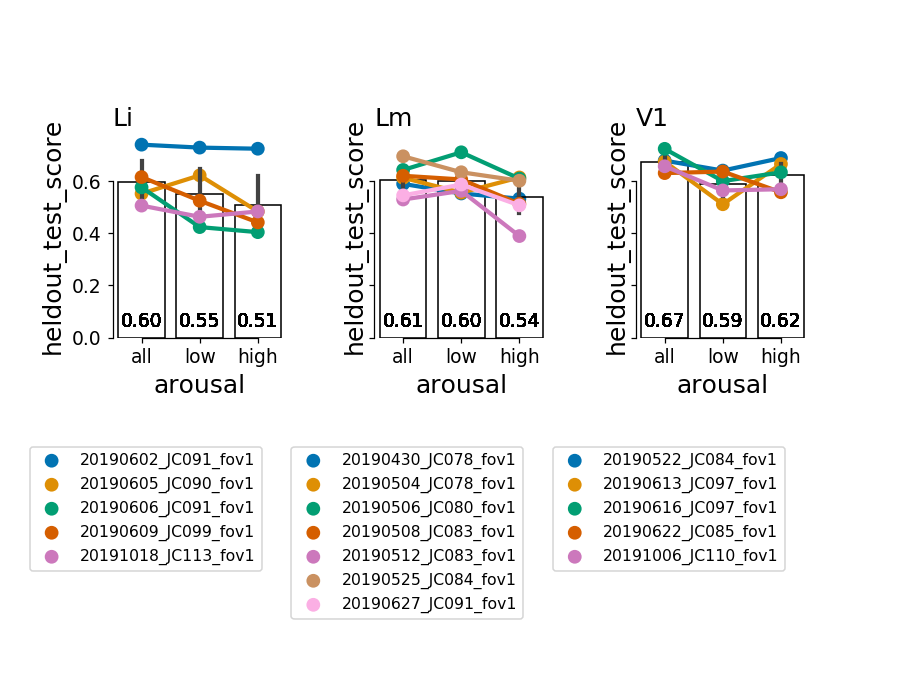

In [123]:
few = [] #['20191018_JC113_fov1', '20190605_JC090_fov1']
metric='heldout_test_score'
#metric='heldout_aMI'

m_ = pd.concat([full_df[metric], lo_df[metric], hi_df[metric]], axis=1)
m_.columns = ['all', 'low', 'high']
# m_df['datakey'] = full_df['datakey']
m_df = m_.unstack().reset_index().rename(columns={'level_0': 'arousal', 'level_1': 'datakey', 0: metric})

m_df['datakey'] = [full_df.loc[i]['datakey'] for i in m_df['datakey']]
#m_df['visual_area'] = [full_df.loc[i]['visual_area'] for i in m_df['datakey']]
v_labels = pd.concat([full_df['visual_area'], lo_df['visual_area'], hi_df['visual_area']], axis=0).values
m_df['visual_area'] = v_labels

plotdf = m_df[~m_df['datakey'].isin(few)]

# plot
ai=0
fig, axn = pl.subplots(1, 3, figsize=(8,6), dpi=dpi, sharex=True, sharey=True)
for ax, (visual_area, a_df) in zip(axn.flat, plotdf.groupby(['visual_area'])):
    sns.pointplot(x='arousal', y=metric, hue='datakey', data=a_df, ax=ax, palette='colorblind',
                 s=10, join=True)
    sns.barplot(x='arousal', y=metric, data=a_df, ax=ax, 
                edgecolor=('k', 'k', 'k'), facecolor=(1,1,1,0))
    m_df.apply(aggr.annotateBars, ax=ax, axis=1, fontsize=12, fontcolor='k')
    #ax.legend(bbox_to_anchor=(1.1, 1))
#     if ai!=2:
#         ax.legend_.remove()
#     else:
    ax.set_title(visual_area, loc='left', fontsize=16)
    
    ax.legend(bbox_to_anchor=(0.9, -0.5))
    ai+=1
pl.subplots_adjust(wspace=0.5, bottom=0.5, top=0.8)
sns.despine(trim=True)

In [202]:
few = [] #['20191018_JC113_fov1', '20190605_JC090_fov1']

<IPython.core.display.Javascript object>


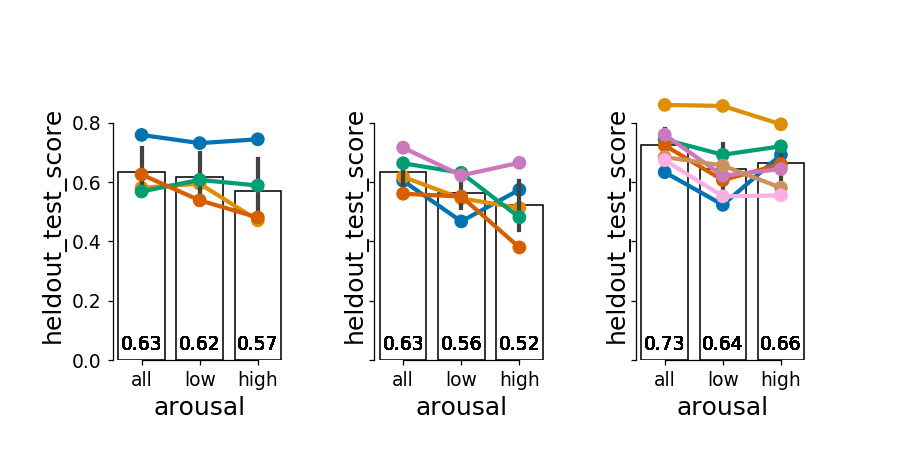

In [203]:
metric='heldout_test_score'

m_ = pd.concat([full_df[metric], lo_df[metric], hi_df[metric]], axis=1)
m_.columns = ['all', 'low', 'high']
# m_df['datakey'] = full_df['datakey']
m_df = m_.unstack().reset_index().rename(columns={'level_0': 'arousal', 'level_1': 'datakey', 0: metric})

m_df['datakey'] = [full_df.loc[i]['datakey'] for i in m_df['datakey']]
#m_df['visual_area'] = [full_df.loc[i]['visual_area'] for i in m_df['datakey']]
v_labels = pd.concat([full_df['visual_area'], lo_df['visual_area'], hi_df['visual_area']], axis=0).values
m_df['visual_area'] = v_labels

plotdf = m_df[~m_df['datakey'].isin(few)]

# plot
fig, axn = pl.subplots(1, 3, figsize=(8,4), dpi=dpi, sharex=True, sharey=True)
for ax, (arousal, a_df) in zip(axn.flat, plotdf.groupby(['visual_area'])):
    sns.pointplot(x='arousal', y=metric, hue='datakey', data=a_df, ax=ax, palette='colorblind',
                 s=10, join=True)
    sns.barplot(x='arousal', y=metric, data=a_df, ax=ax, 
                edgecolor=('k', 'k', 'k'), facecolor=(1,1,1,0))
    m_df.apply(aggr.annotateBars, ax=ax, axis=1, fontsize=12, fontcolor='k')
    #ax.legend(bbox_to_anchor=(1.1, 1))
    ax.legend_.remove()
pl.subplots_adjust(wspace=0.5, bottom=0.2, top=0.8)
sns.despine(trim=True)

In [101]:
def filter_rois(has_blobs, overlap_thr=0.50):
    visual_areas=['V1', 'Lm', 'Li']
    nocells=[]; notrials=[];
    global_rois = dict((v, []) for v in visual_areas)
    roi_counters = dict((v, 0) for v in visual_areas)
    roidf = []
    datakeys = dict((v, []) for v in visual_areas)
    
    for (visual_area, datakey), g in has_blobs[has_blobs['perc_overlap']>=overlap_thr].groupby(['visual_area', 'datakey']):

        roi_counter = roi_counters[visual_area]
        datakeys[visual_area].append(datakey)

        #ddf.sort_values(by='config')
        roi_list = sorted([s for s in g['cell'].unique()]) #[int(r) for r in ddf.columns if r != 'config']

        # Reindex roi ids for global
        roi_ids = [i+roi_counter for i, r in enumerate(roi_list)]
        nrs = len(roi_list)

        global_rois[visual_area].extend(roi_ids)
        roidf.append(pd.DataFrame({'roi': roi_ids,
                                   'dset_roi': roi_list,
                                   'visual_area': [visual_area for _ in np.arange(0, nrs)],
                                   'datakey': [datakey for _ in np.arange(0, nrs)]}))

        # Update global roi id counter
        roi_counters[visual_area] += len(roi_ids)

    roidf = pd.concat(roidf, axis=0) #.groupby(['visual_area']).count()
    #print("%i datasets fail all thresholds:" % len(nocells), nocells)
    for k, v in global_rois.items():
        print(k, len(v))
        
    return roidf